In [3]:
import pandas as pd
import sys

sys.path.append('..')
from stattool.empirical_design import check_aa
from stattool.plot_tool import plot_cdf
from scipy.stats import norm, ttest_ind
from stattool import proportion_ztest, calc_t_test_lin
from stattool.theoretical_design import get_parameter_size

# 15 min agg

In [29]:
on_line_cars = pd.read_parquet('../results/saev_online_cars_day_100.parquet')
on_line_cars['agg'] = pd.to_datetime(on_line_cars['timestamp']).dt.floor('15min')

In [30]:
trips_table = pd.read_parquet('../results/saev_completed_trips_day_100.parquet')

trips_table['agg'] = trips_table['request_datetime'].dt.floor('15min')
trips_table['net_revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee'] - trips_table['driver_pay']
trips_table['revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']

In [31]:
assigned = trips_table[trips_table['assigned'] == True]


metrics = trips_table.groupby('agg')[['net_revenue', 'revenue', 'trip_time', 'trip_miles']].sum().reset_index()\
                .rename(columns={'trip_time': 'time_with_passenger'})

In [32]:
aggregated_on_line_cars = on_line_cars.groupby(['agg', 'car_id'])['timestamp'].agg(['min', 'max'])
aggregated_on_line_cars['on_line_time'] = (pd.to_datetime(aggregated_on_line_cars['max']) - pd.to_datetime(aggregated_on_line_cars['min']))\
                            .dt.total_seconds()
metrics = metrics.merge(aggregated_on_line_cars.groupby(['agg'])['on_line_time'].sum().reset_index(), on='agg')

In [33]:
metrics = metrics.merge(trips_table.pivot_table(index='agg', 
                        columns='assigned', 
                        values='trip_id', 
                        aggfunc='count').reset_index().rename(columns={False:'missed_trips', True:'completed_trips'}),
                      on='agg')

In [34]:
metrics['cnt_trips'] = metrics['completed_trips'] + metrics['missed_trips']

In [35]:
co2_per_km = 0.4 
metrics['co2_emissions'] = co2_per_km * metrics['trip_miles'] * 0.62 # 06 miles = 1 km 

In [36]:
metrics['default'] = 1

In [37]:
metrics.columns

Index(['agg', 'net_revenue', 'revenue', 'time_with_passenger', 'trip_miles',
       'on_line_time', 'missed_trips', 'completed_trips', 'cnt_trips',
       'co2_emissions', 'default'],
      dtype='object')

In [41]:
metrics['on_line_time'].max()

84000.0

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1419.06it/s]


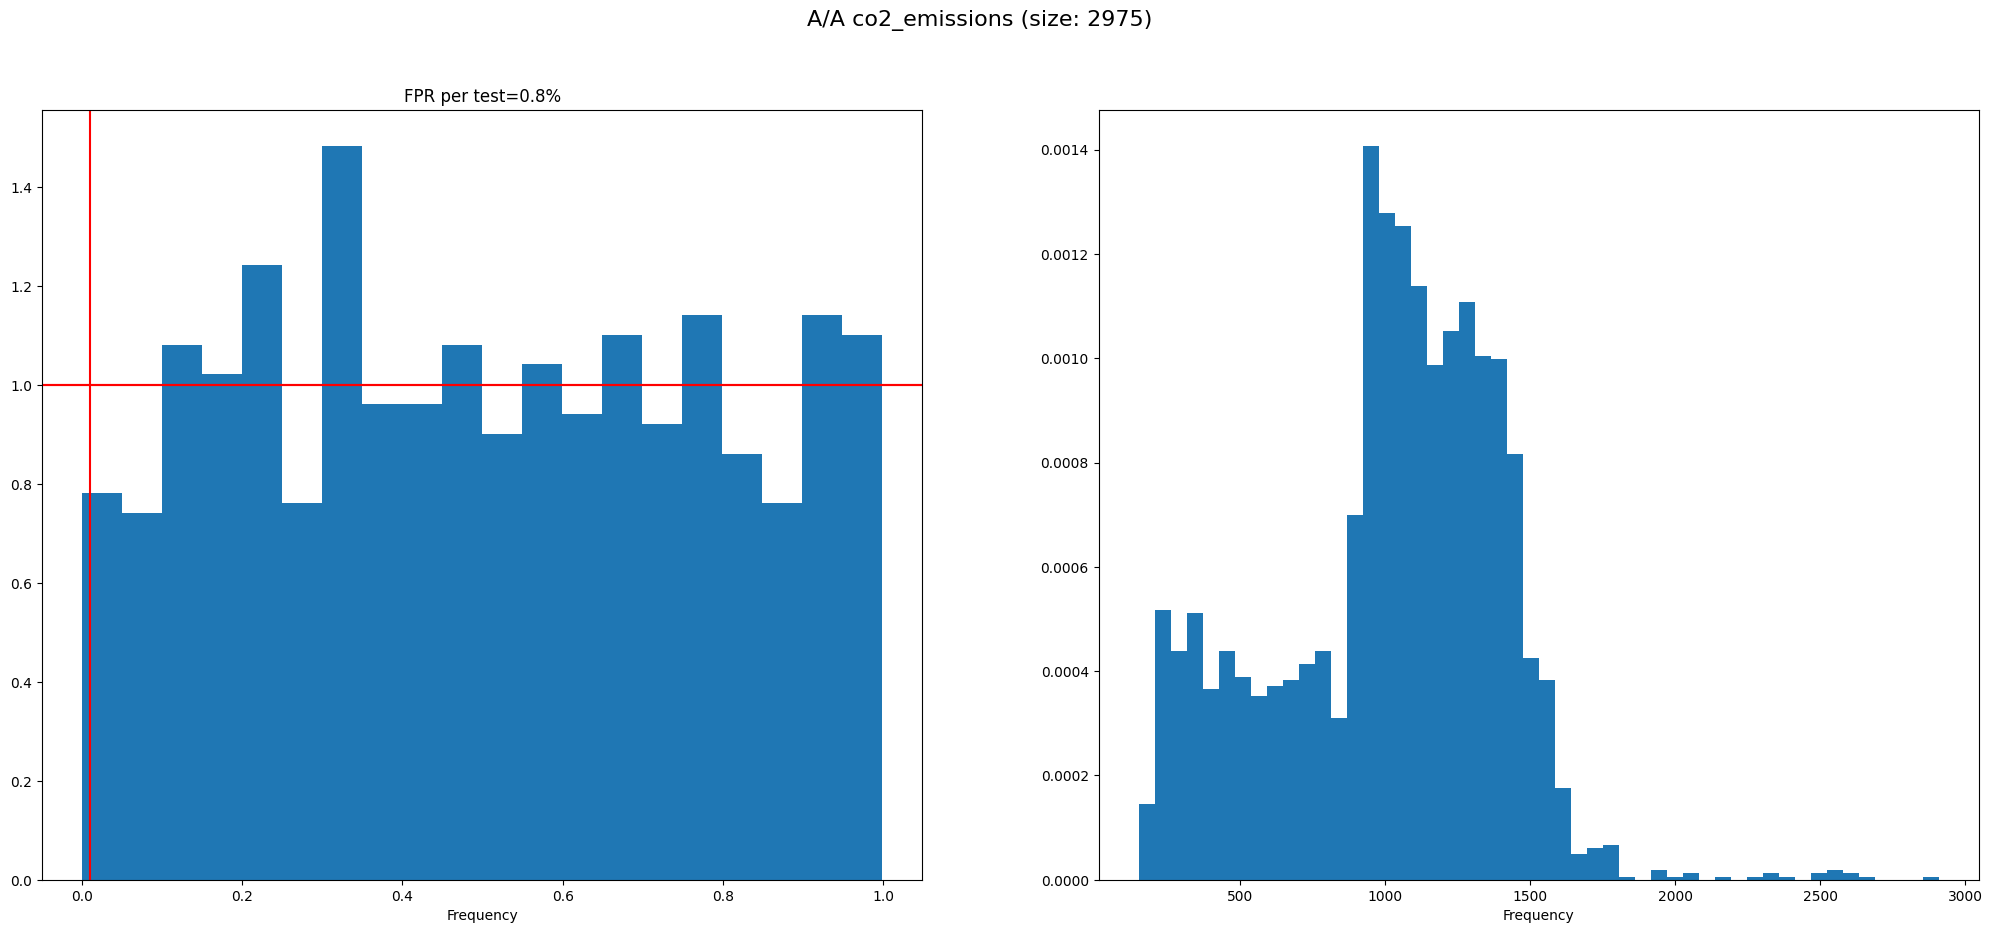

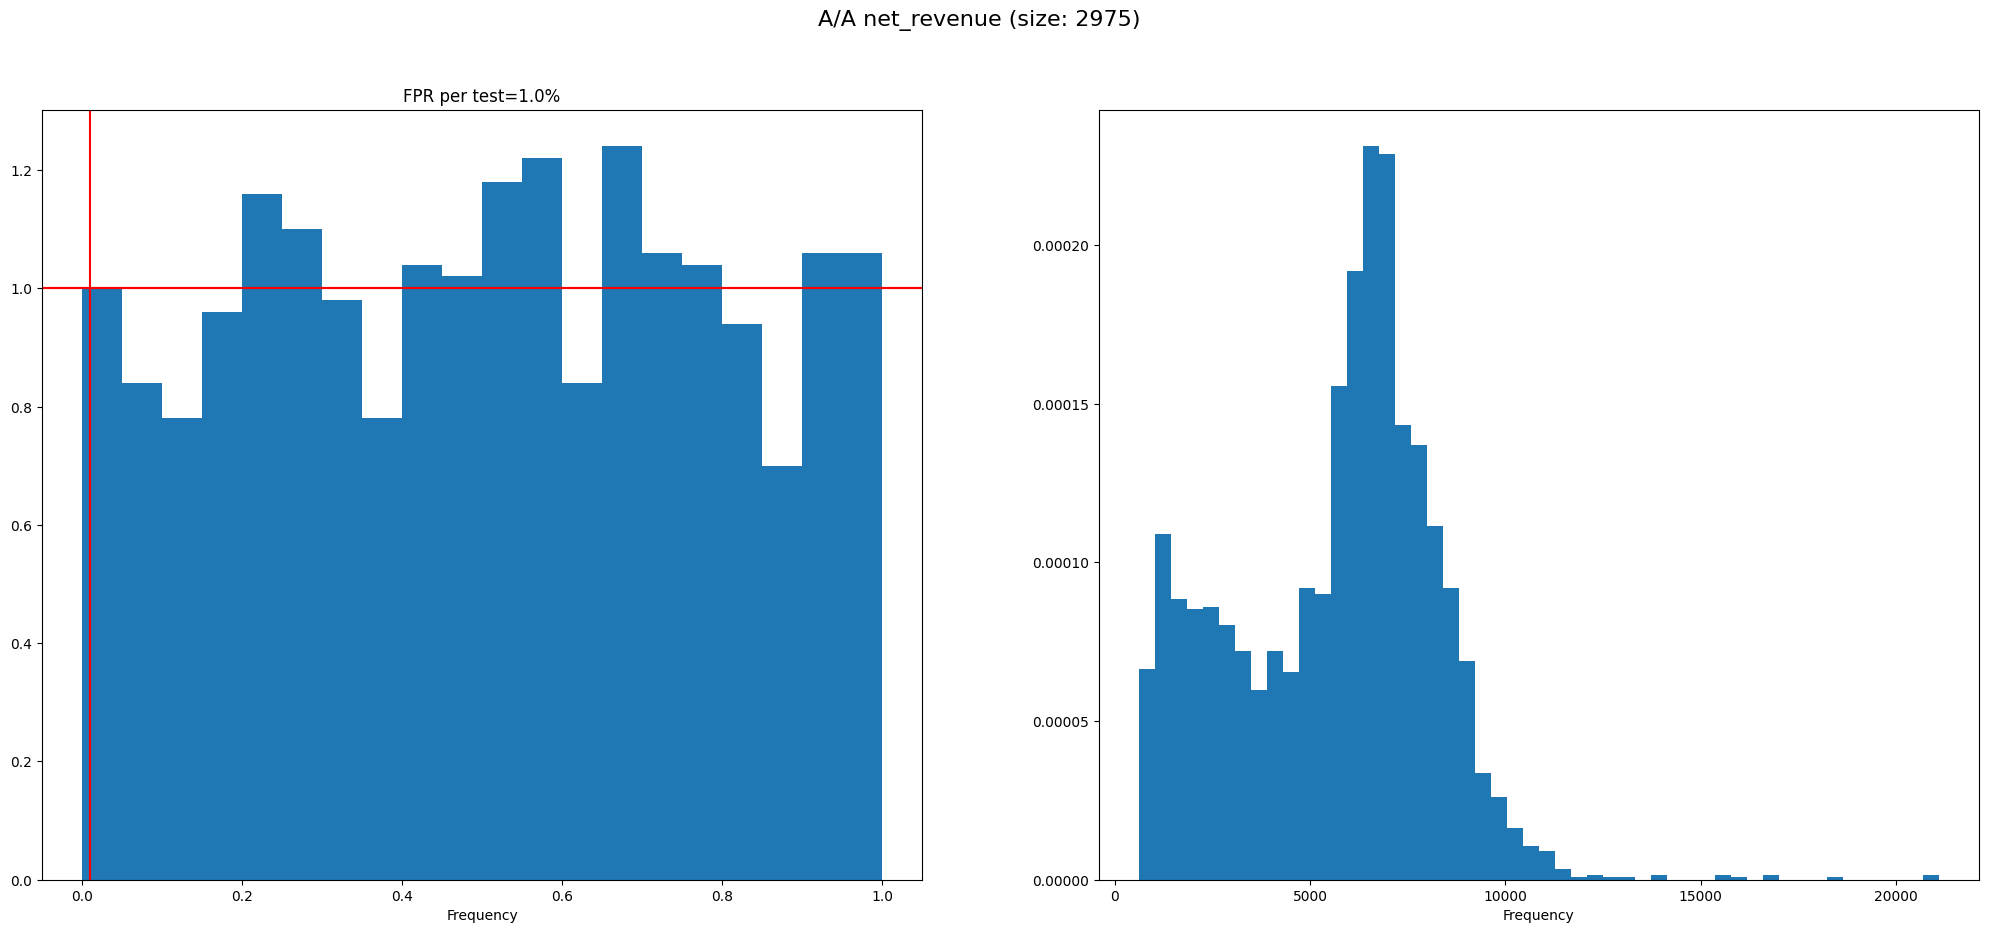

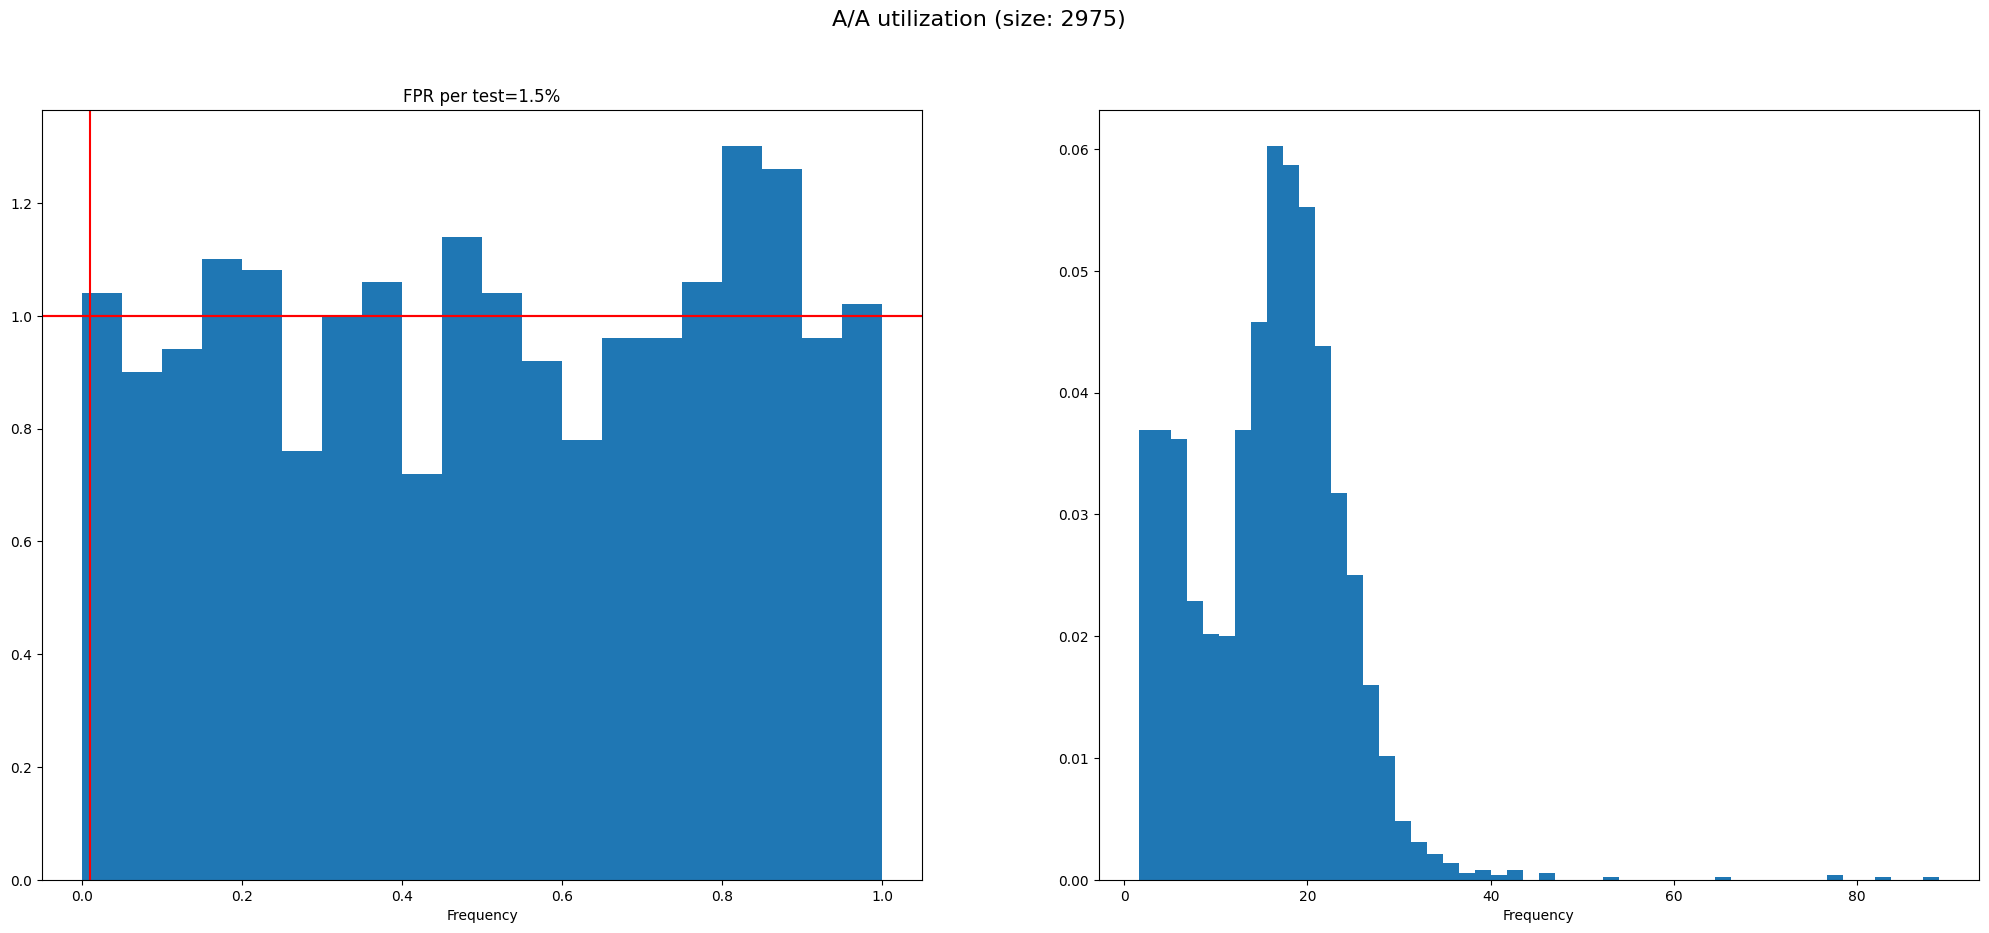

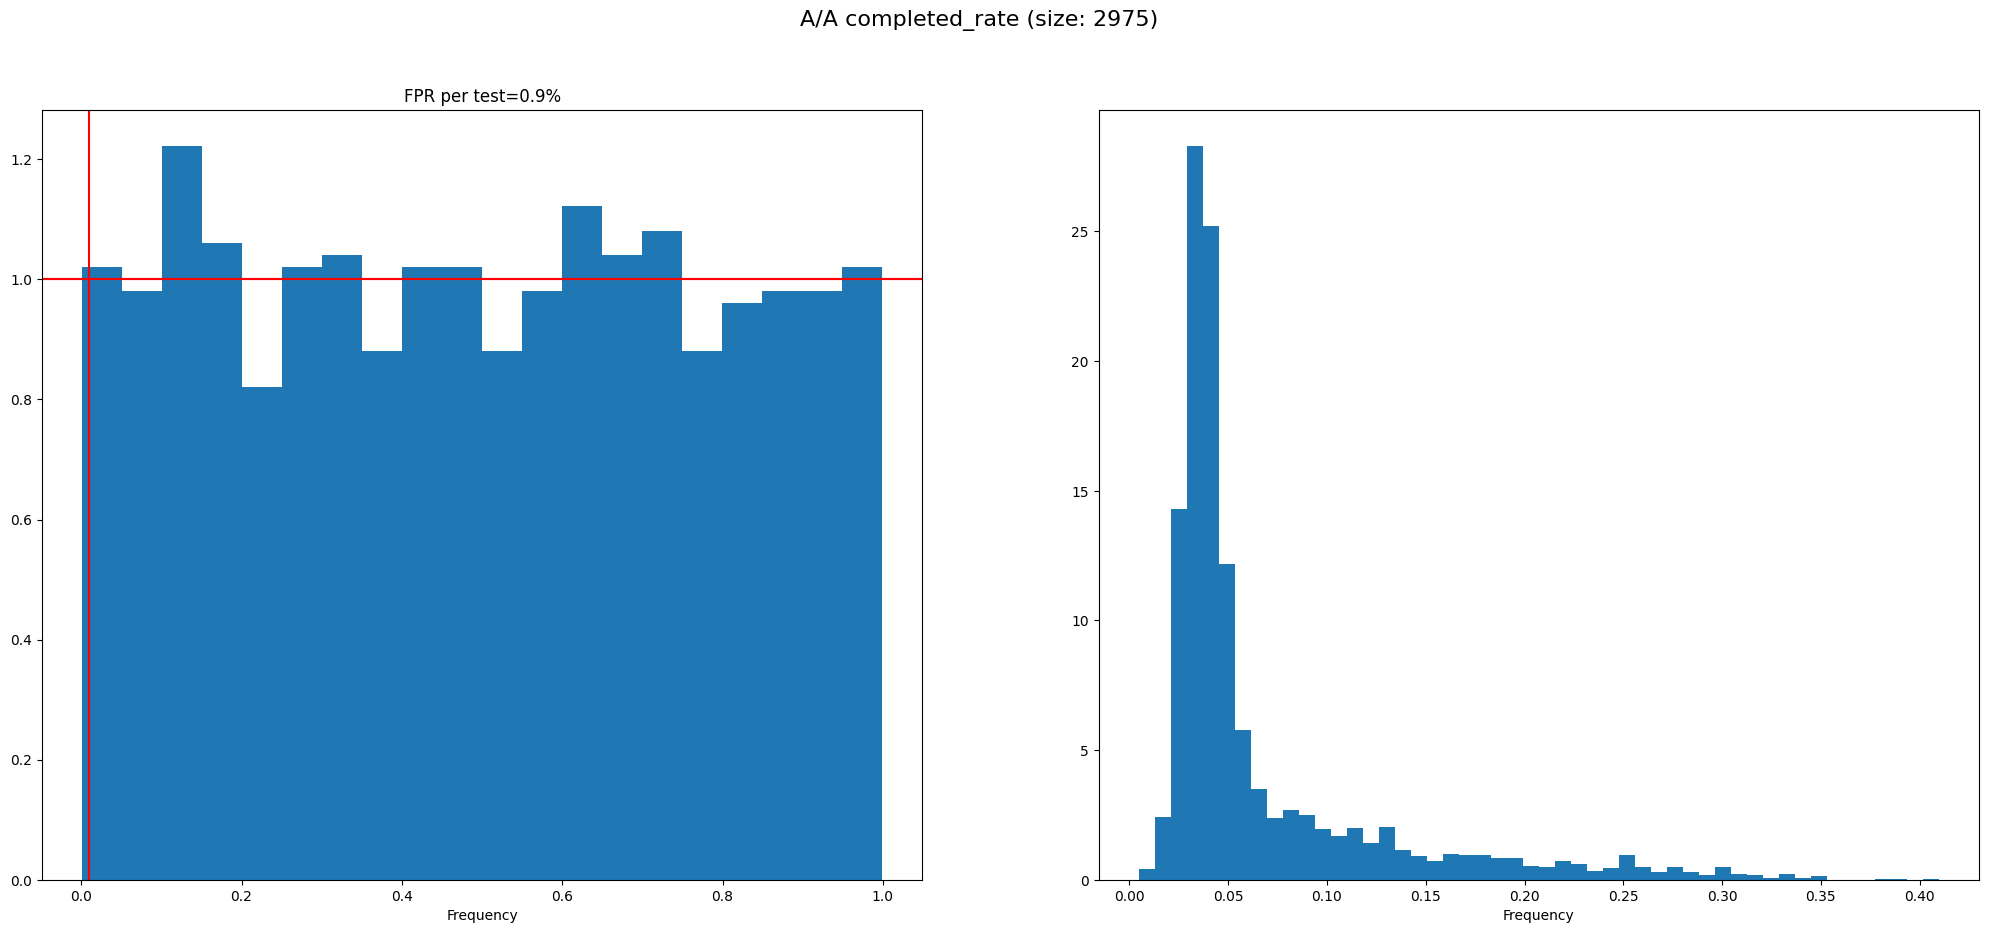

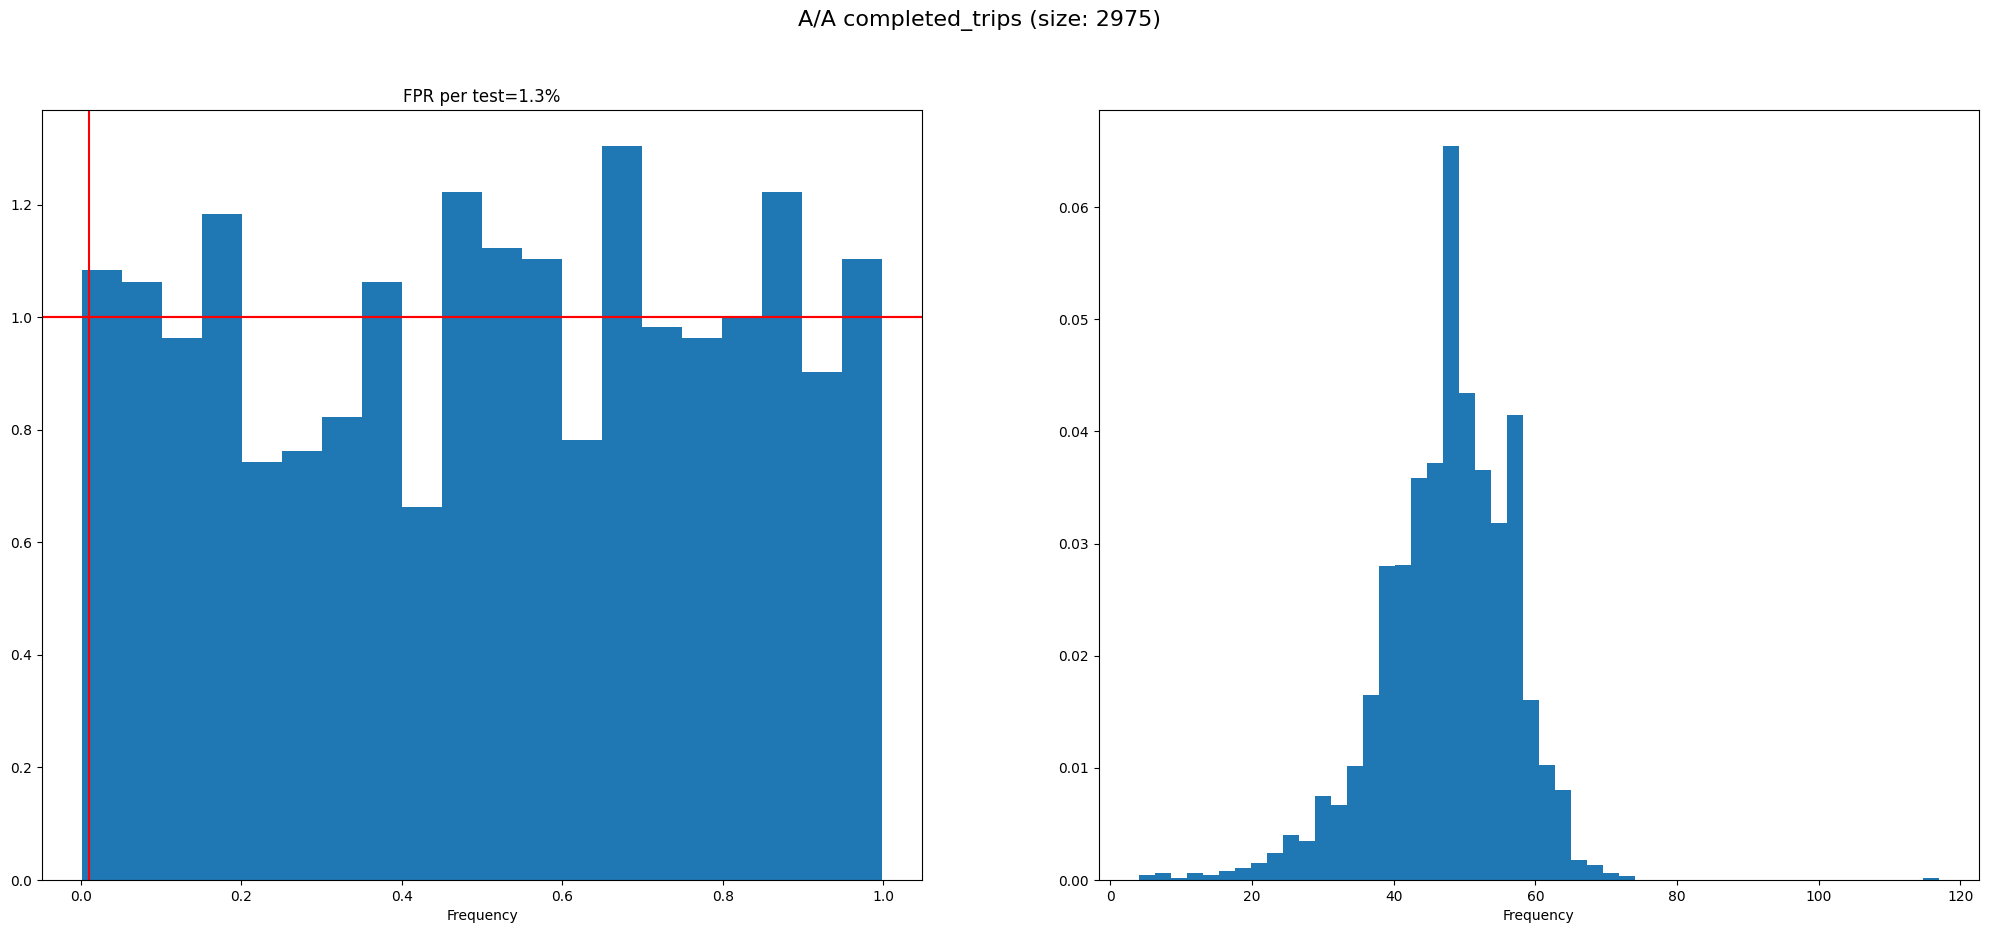

In [93]:
N = 1000
metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_rate': {'nominator': 'completed_trips', 'denominator': 'cnt_trips'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }

for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    p_values = check_aa(metrics, nominator=nom, denominator=den, N=N)

    metric_value = metrics[nom]/metrics[den]
    plot_cdf(p_values.reshape(N), metric_value, f'A/A {metric_name}', alpha=0.01)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Users/enbelodedova/Documents/diploma.simulation/analysis/../stattool/stat_test.py:112: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1207.48it/s]


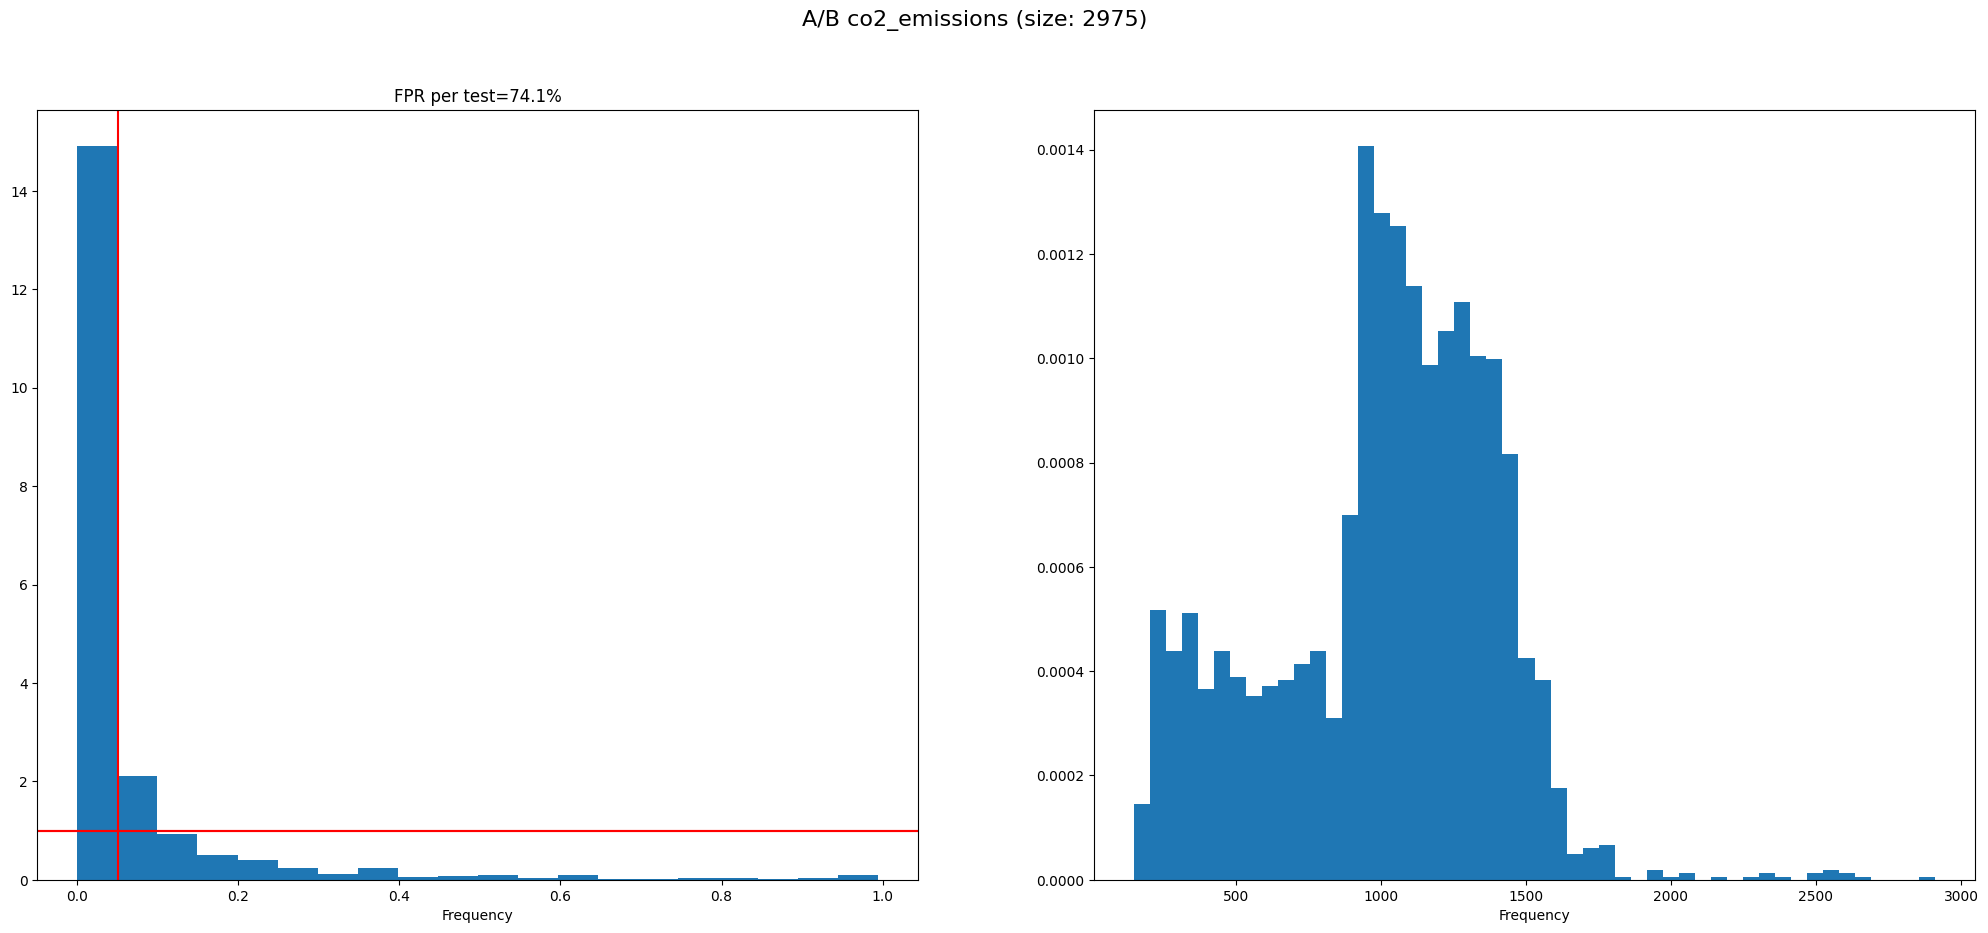

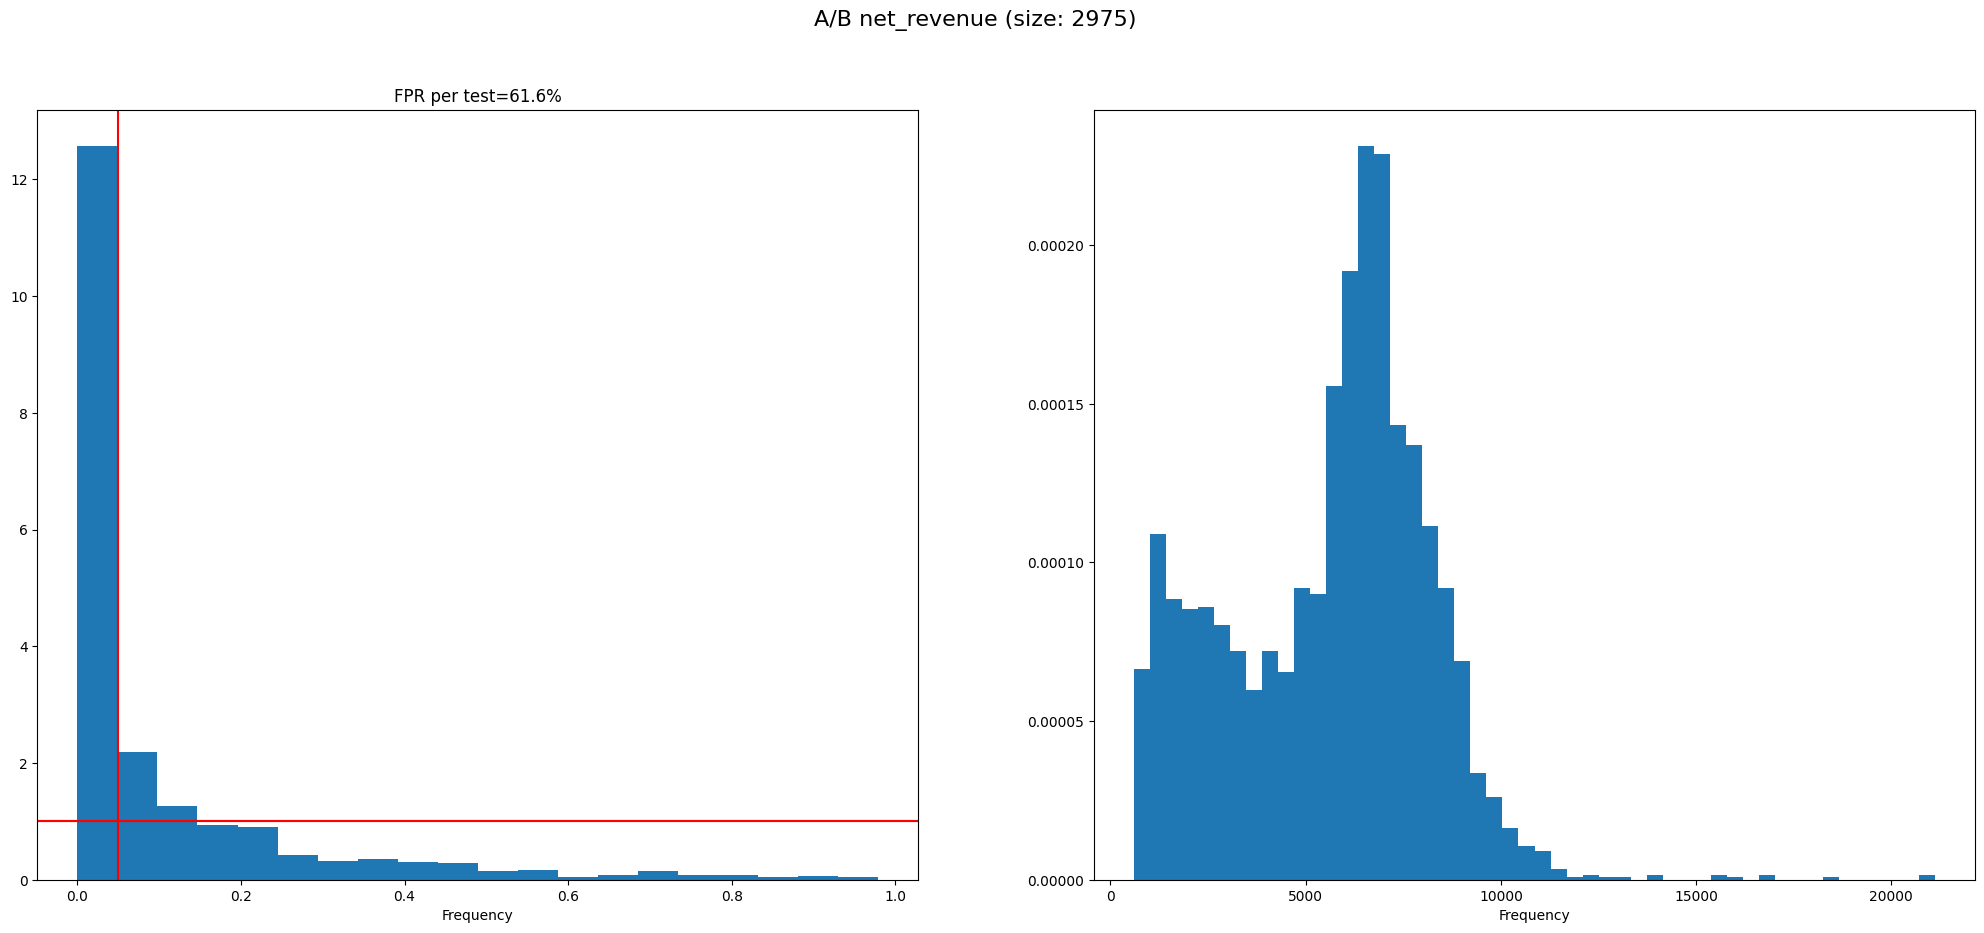

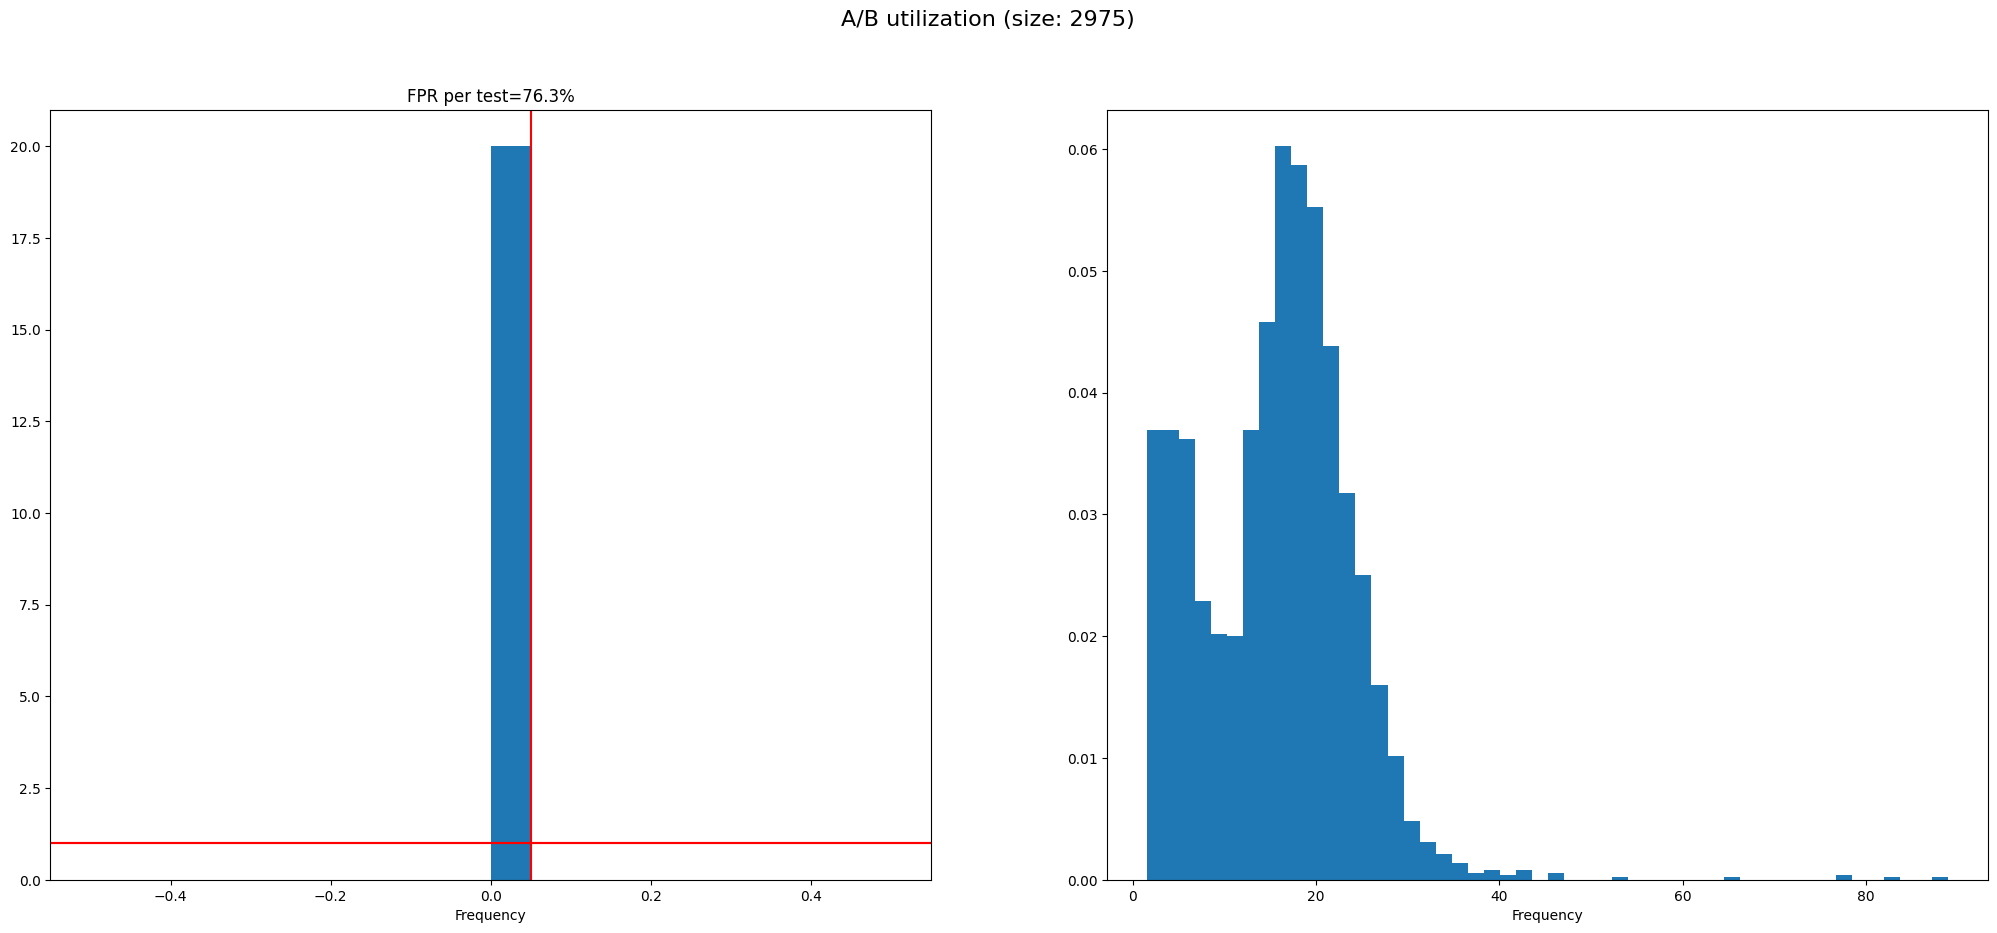

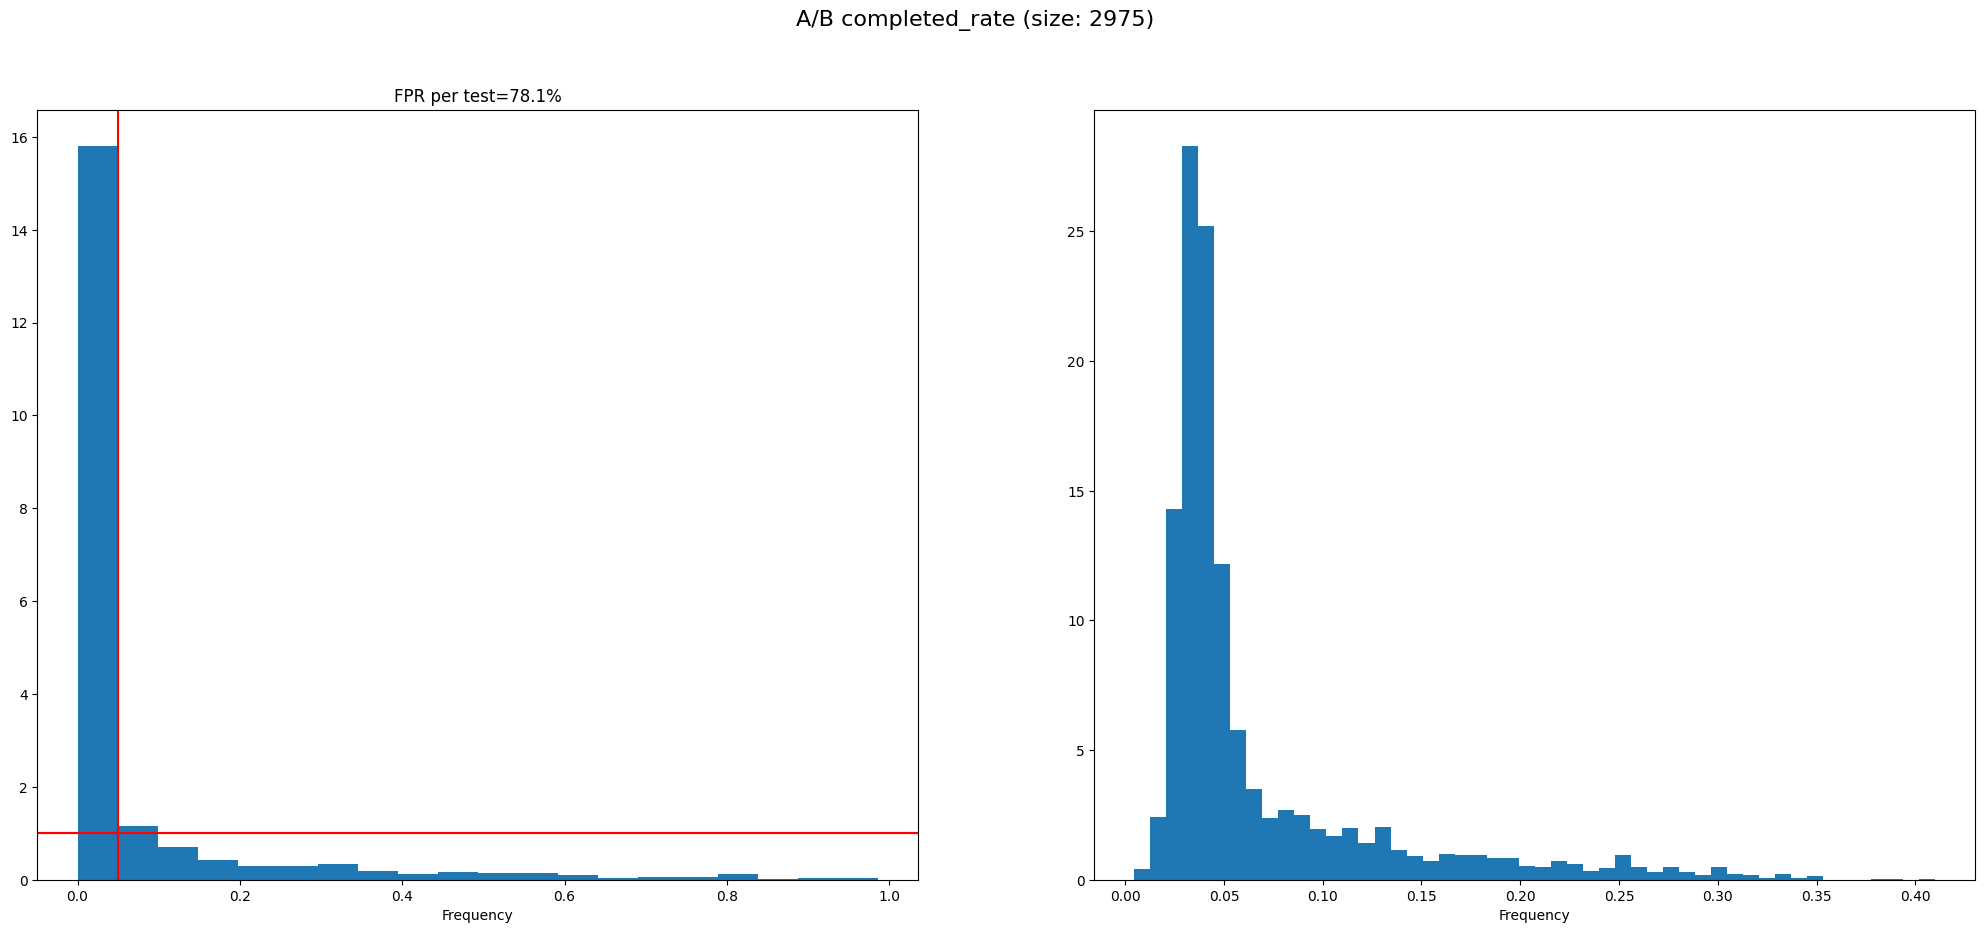

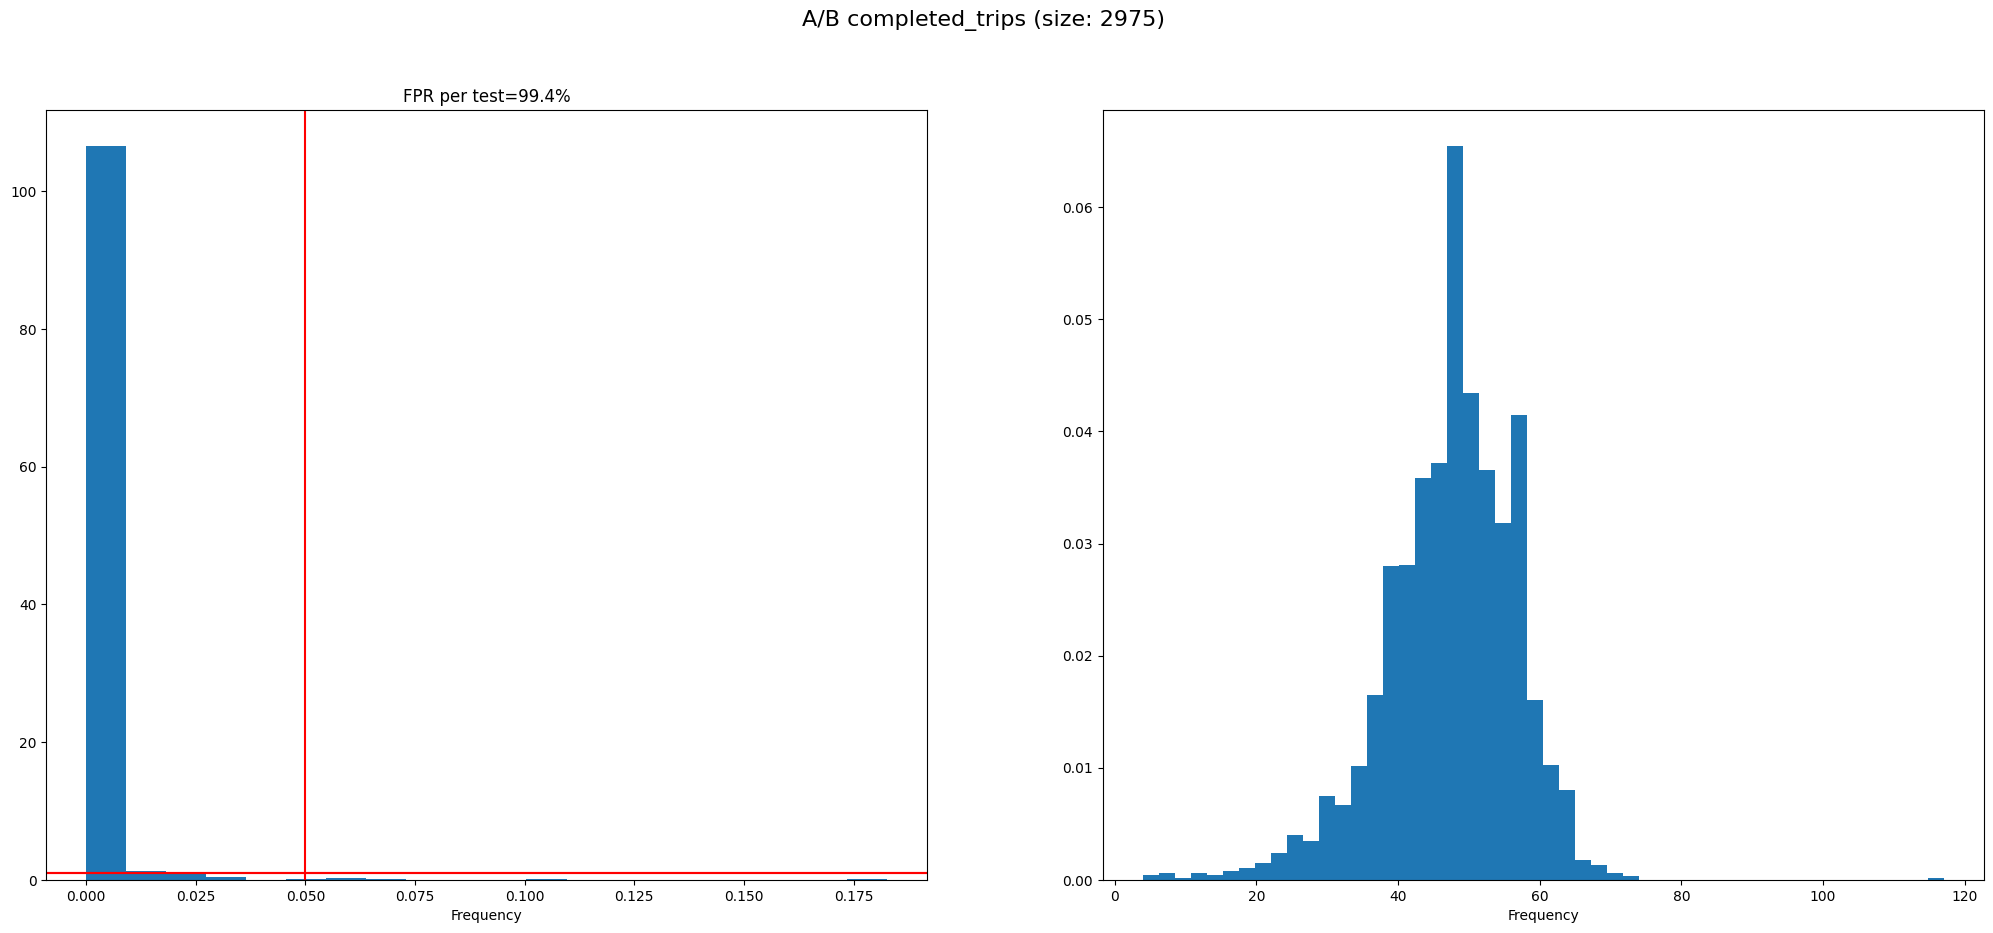

In [96]:
N = 1000
metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_rate': {'nominator': 'completed_trips', 'denominator': 'cnt_trips'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }

for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    p_values = check_aa(metrics, nominator=nom, denominator=den, N=N, effects=[0, 0.04], error_type = "II error")

    metric_value = metrics[nom]/metrics[den]
    plot_cdf(p_values.reshape(N), metric_value, f'A/B {metric_name}')

In [101]:
for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    effect_size = get_parameter_size(nominator=metrics[nom], parameter='effect', denominator=metrics[den], alpha=0.01)
    print(f'{metric_name}: ', effect_size)

co2_emissions:  4.76
net_revenue:  5.68
utilization:  6.06
completed_rate:  6.09
completed_trips:  2.43


# 10 min agg

In [4]:
on_line_cars = pd.read_parquet('../results/saev_online_cars_day_100.parquet')
on_line_cars['agg'] = pd.to_datetime(on_line_cars['timestamp']).dt.floor('10min')

trips_table = pd.read_parquet('../results/saev_completed_trips_day_100.parquet')

trips_table['agg'] = trips_table['request_datetime'].dt.floor('10min')
trips_table['net_revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee'] - trips_table['driver_pay']
trips_table['revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']

assigned = trips_table[trips_table['assigned'] == True]


metrics = trips_table.groupby('agg')[['net_revenue', 'revenue', 'trip_time', 'trip_miles']].sum().reset_index()\
                .rename(columns={'trip_time': 'time_with_passenger'})

aggregated_on_line_cars = on_line_cars.groupby(['agg', 'car_id'])['timestamp'].agg(['min', 'max'])
aggregated_on_line_cars['on_line_time'] = (pd.to_datetime(aggregated_on_line_cars['max']) - pd.to_datetime(aggregated_on_line_cars['min']))\
                            .dt.total_seconds()
metrics = metrics.merge(aggregated_on_line_cars.groupby(['agg'])['on_line_time'].sum().reset_index(), on='agg')

metrics = metrics.merge(trips_table.pivot_table(index='agg', 
                        columns='assigned', 
                        values='trip_id', 
                        aggfunc='count').reset_index().rename(columns={False:'missed_trips', True:'completed_trips'}),
                      on='agg')

metrics['cnt_trips'] = metrics['completed_trips'] + metrics['missed_trips']

co2_per_km = 0.4 
metrics['co2_emissions'] = co2_per_km * metrics['trip_miles'] * 0.62 # 06 miles = 1 km 

metrics['default'] = 1

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1352.66it/s]


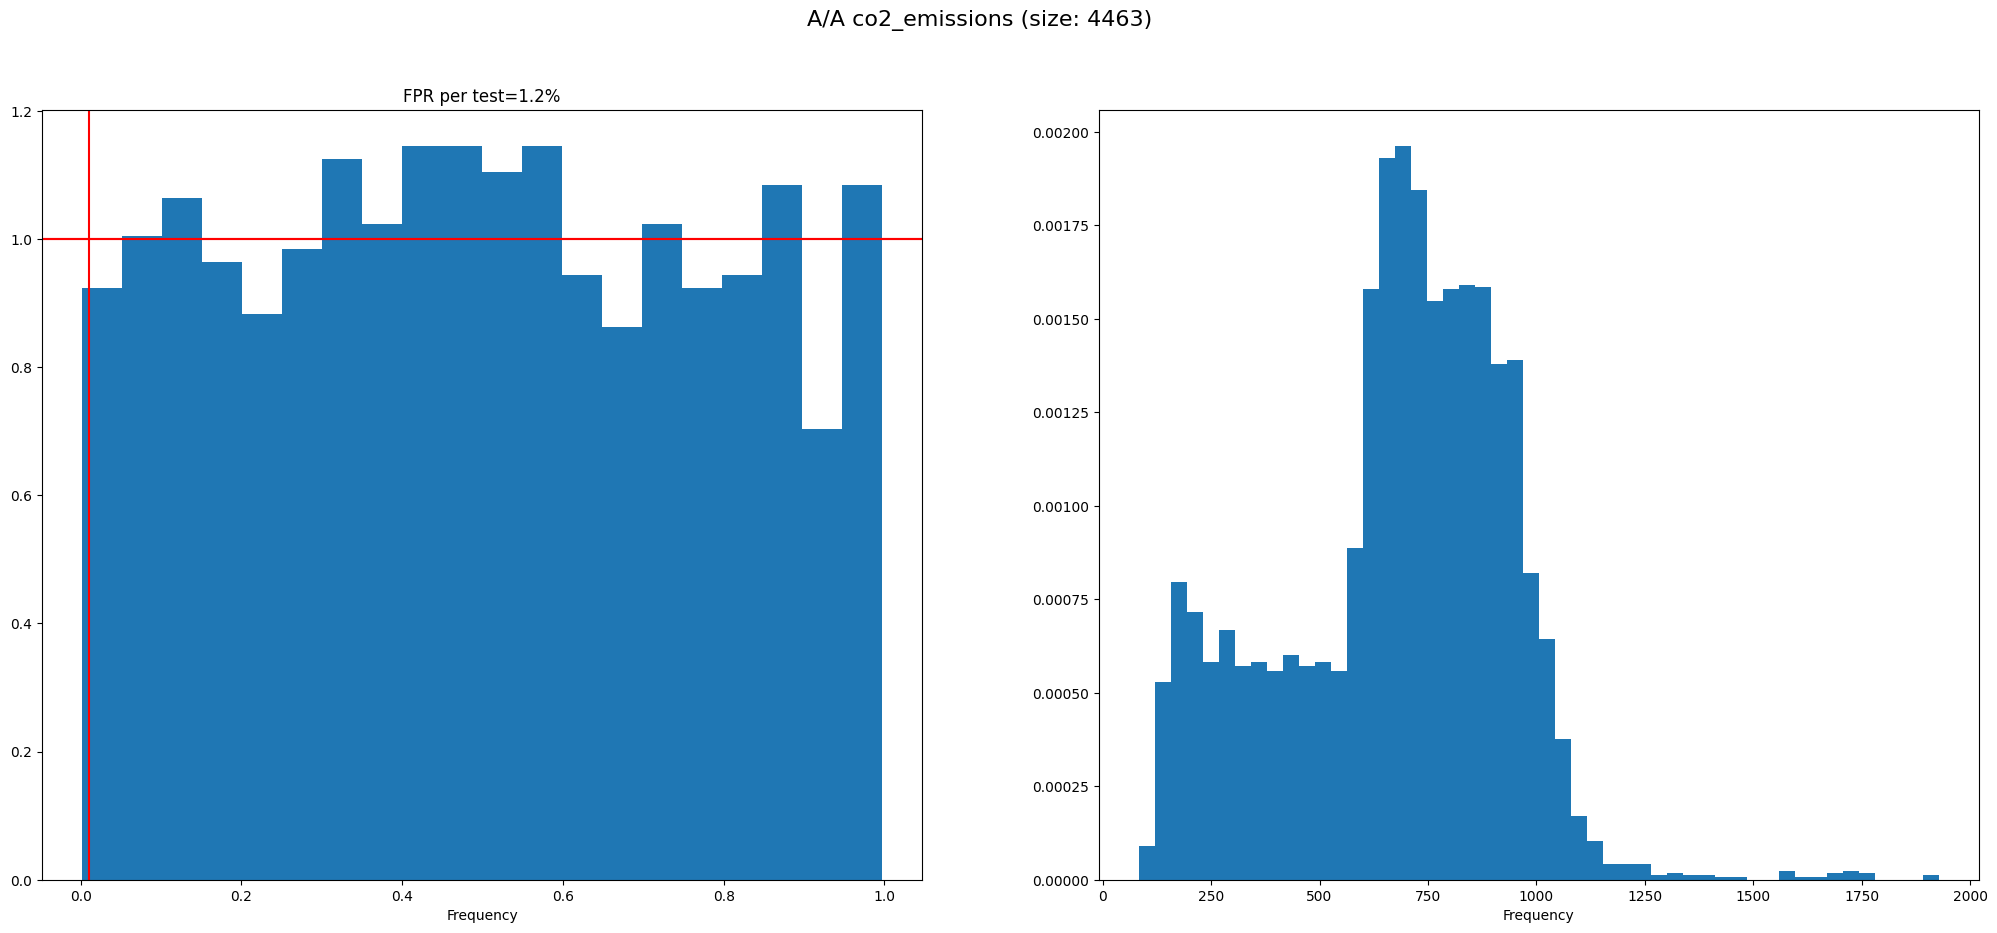

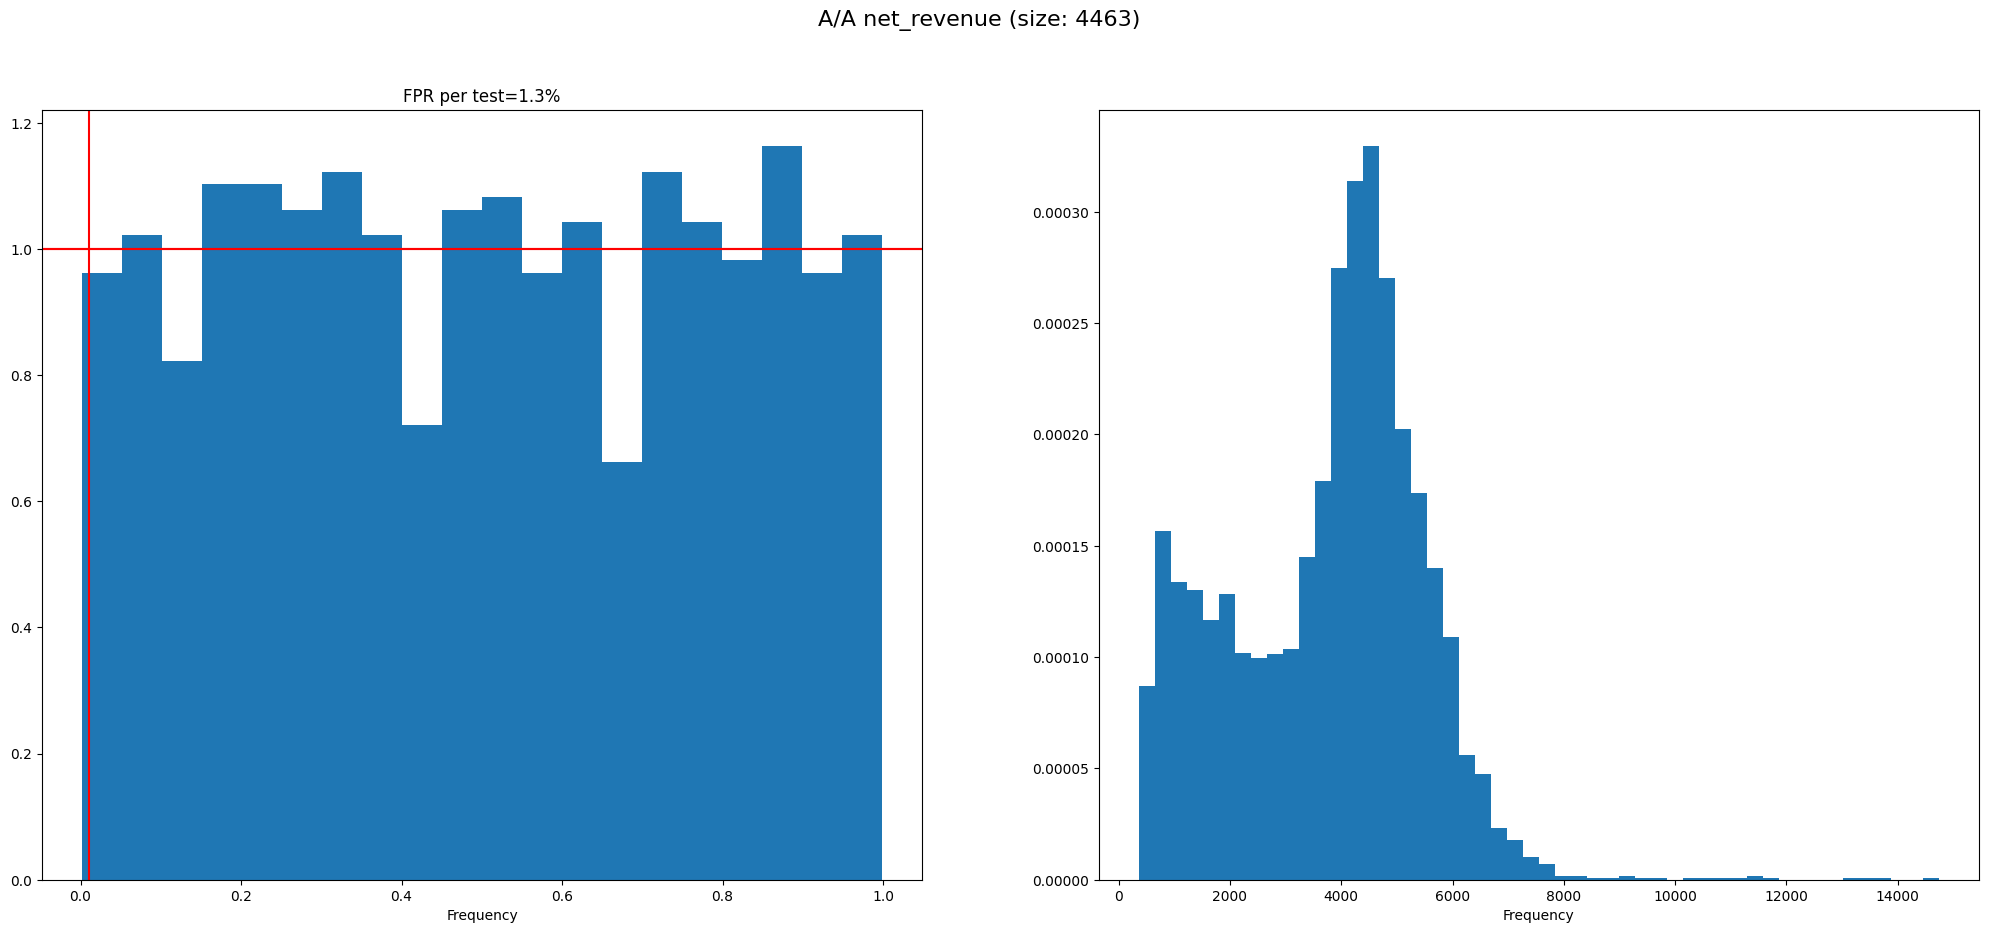

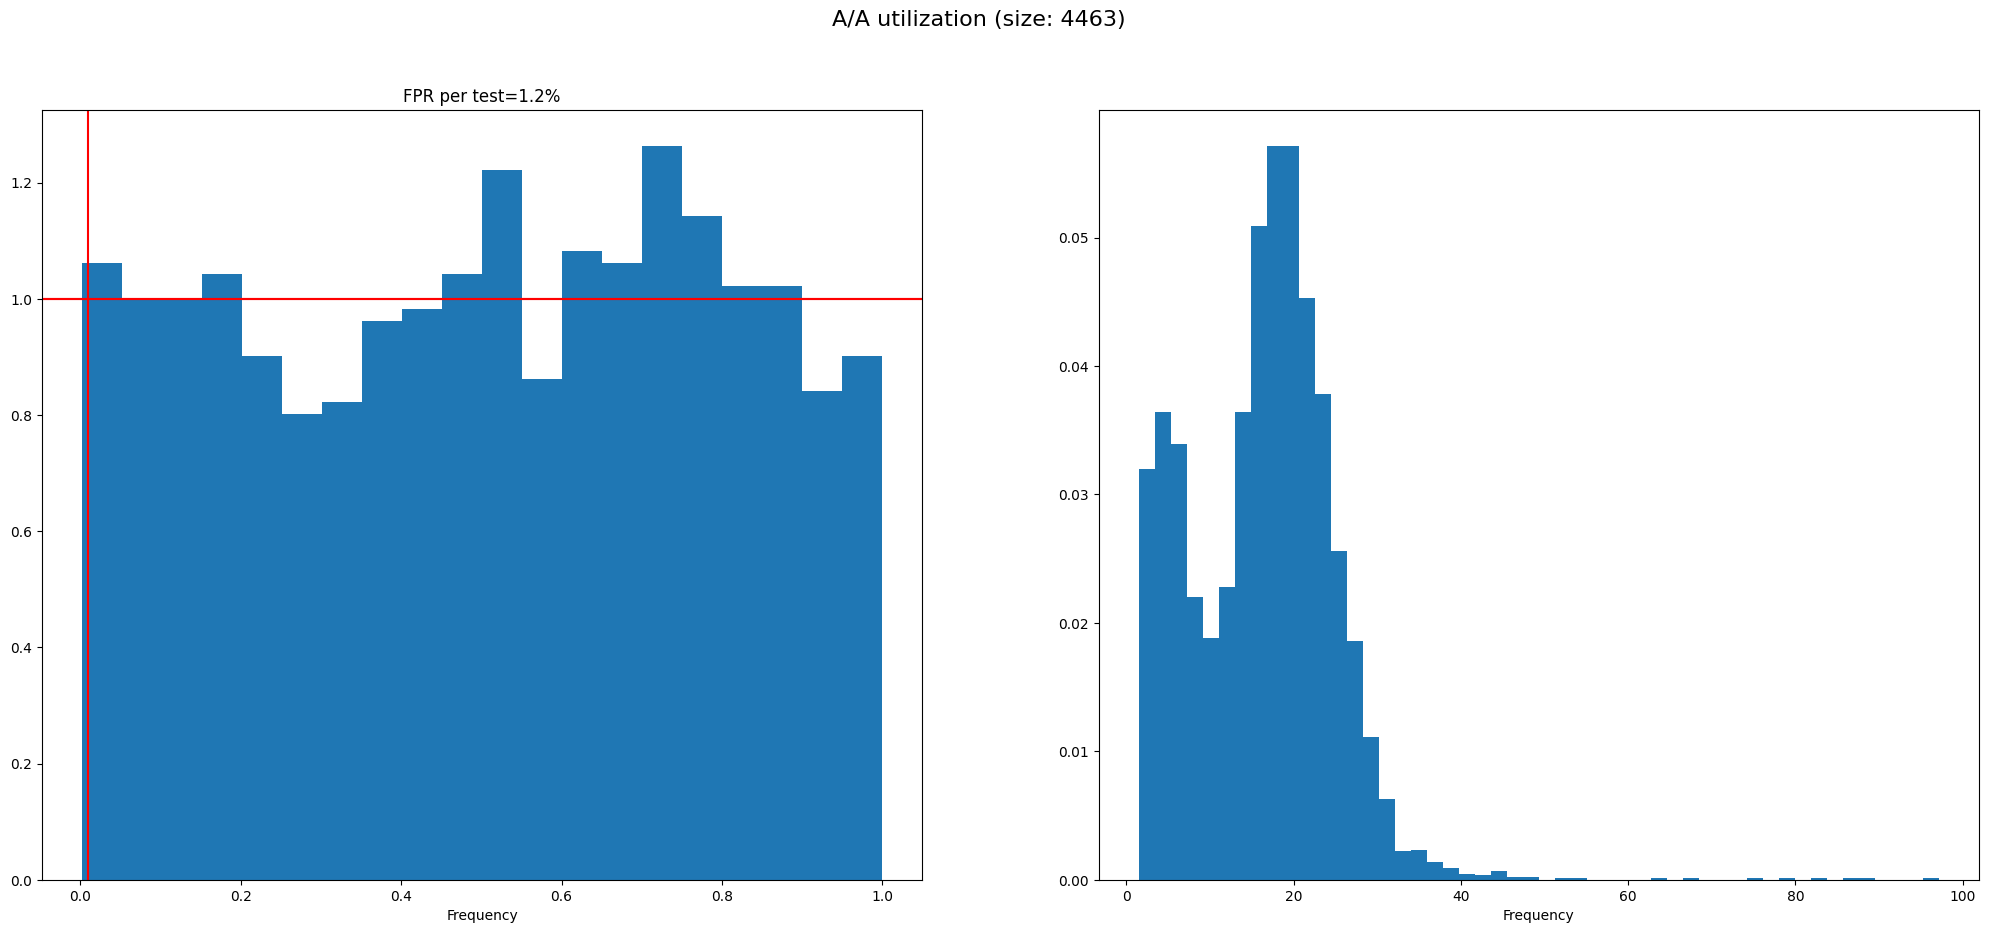

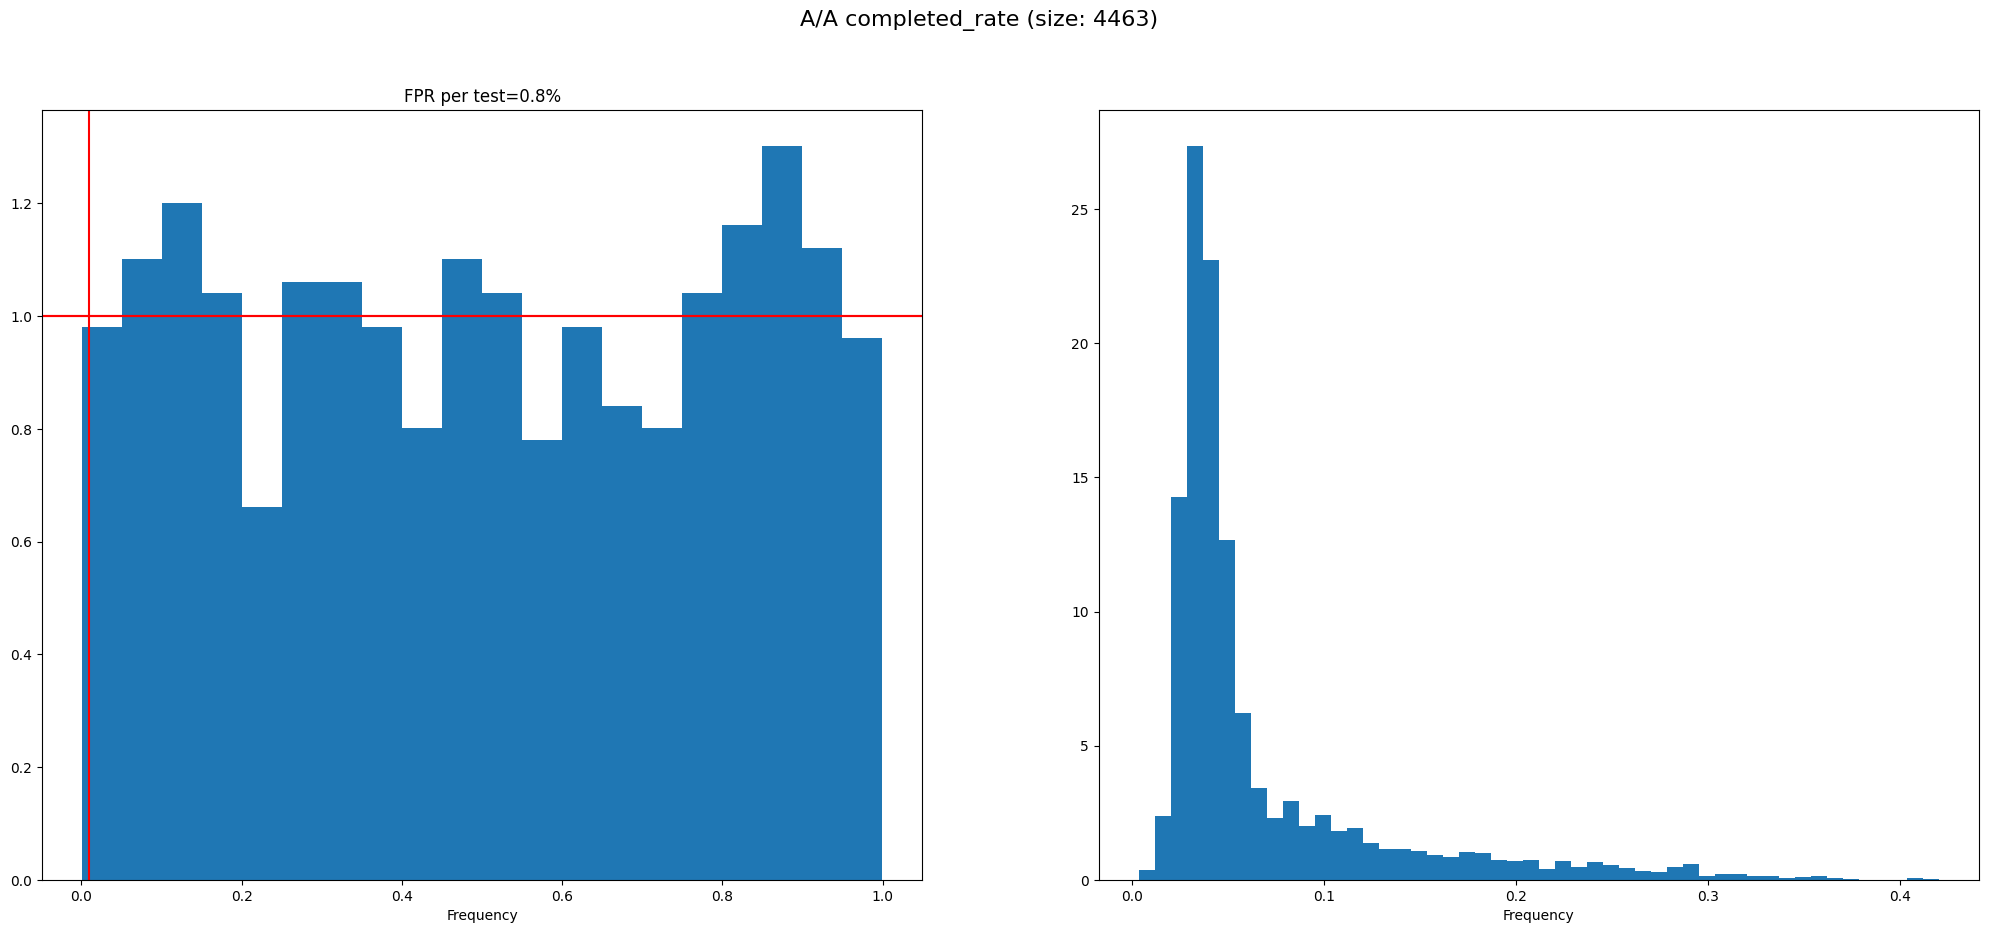

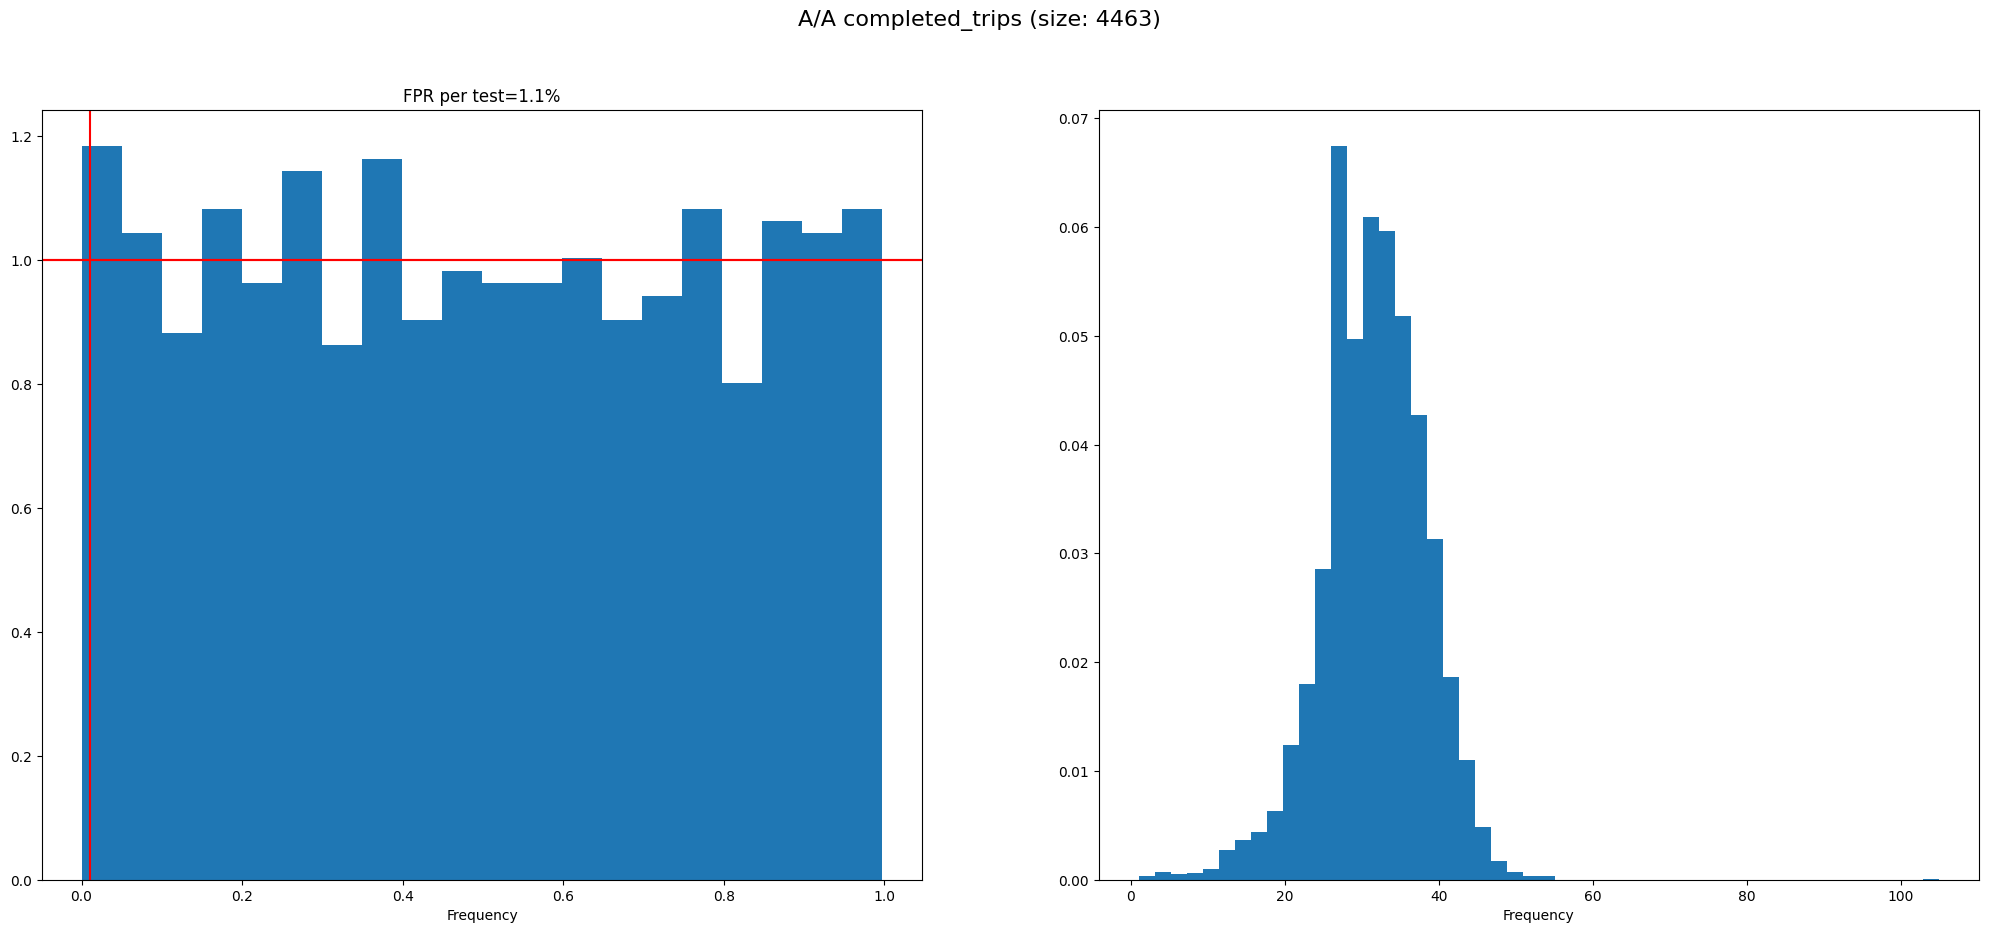

In [5]:
N = 1000
metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_rate': {'nominator': 'completed_trips', 'denominator': 'cnt_trips'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }

for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    p_values = check_aa(metrics, nominator=nom, denominator=den, N=N)

    metric_value = metrics[nom]/metrics[den]
    plot_cdf(p_values.reshape(N), metric_value, f'A/A {metric_name}', alpha=0.01)

In [6]:
for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    effect_size = get_parameter_size(nominator=metrics[nom], parameter='effect', denominator=metrics[den], alpha=0.01)
    print(f'{metric_name}: ', effect_size)

co2_emissions:  3.9
net_revenue:  4.65
utilization:  4.95
completed_rate:  5.07
completed_trips:  2.21


# 5 min agg

In [7]:
on_line_cars = pd.read_parquet('../results/saev_online_cars_day_100.parquet')
on_line_cars['agg'] = pd.to_datetime(on_line_cars['timestamp']).dt.floor('5min')

trips_table = pd.read_parquet('../results/saev_completed_trips_day_100.parquet')

trips_table['agg'] = trips_table['request_datetime'].dt.floor('5min')
trips_table['net_revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee'] - trips_table['driver_pay']
trips_table['revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']

assigned = trips_table[trips_table['assigned'] == True]


metrics = trips_table.groupby('agg')[['net_revenue', 'revenue', 'trip_time', 'trip_miles']].sum().reset_index()\
                .rename(columns={'trip_time': 'time_with_passenger'})

aggregated_on_line_cars = on_line_cars.groupby(['agg', 'car_id'])['timestamp'].agg(['min', 'max'])
aggregated_on_line_cars['on_line_time'] = (pd.to_datetime(aggregated_on_line_cars['max']) - pd.to_datetime(aggregated_on_line_cars['min']))\
                            .dt.total_seconds()
metrics = metrics.merge(aggregated_on_line_cars.groupby(['agg'])['on_line_time'].sum().reset_index(), on='agg')

metrics = metrics.merge(trips_table.pivot_table(index='agg', 
                        columns='assigned', 
                        values='trip_id', 
                        aggfunc='count').reset_index().rename(columns={False:'missed_trips', True:'completed_trips'}),
                      on='agg')

metrics['cnt_trips'] = metrics['completed_trips'] + metrics['missed_trips']

co2_per_km = 0.4 
metrics['co2_emissions'] = co2_per_km * metrics['trip_miles'] * 0.62 # 06 miles = 1 km 

metrics['default'] = 1

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1216.21it/s]


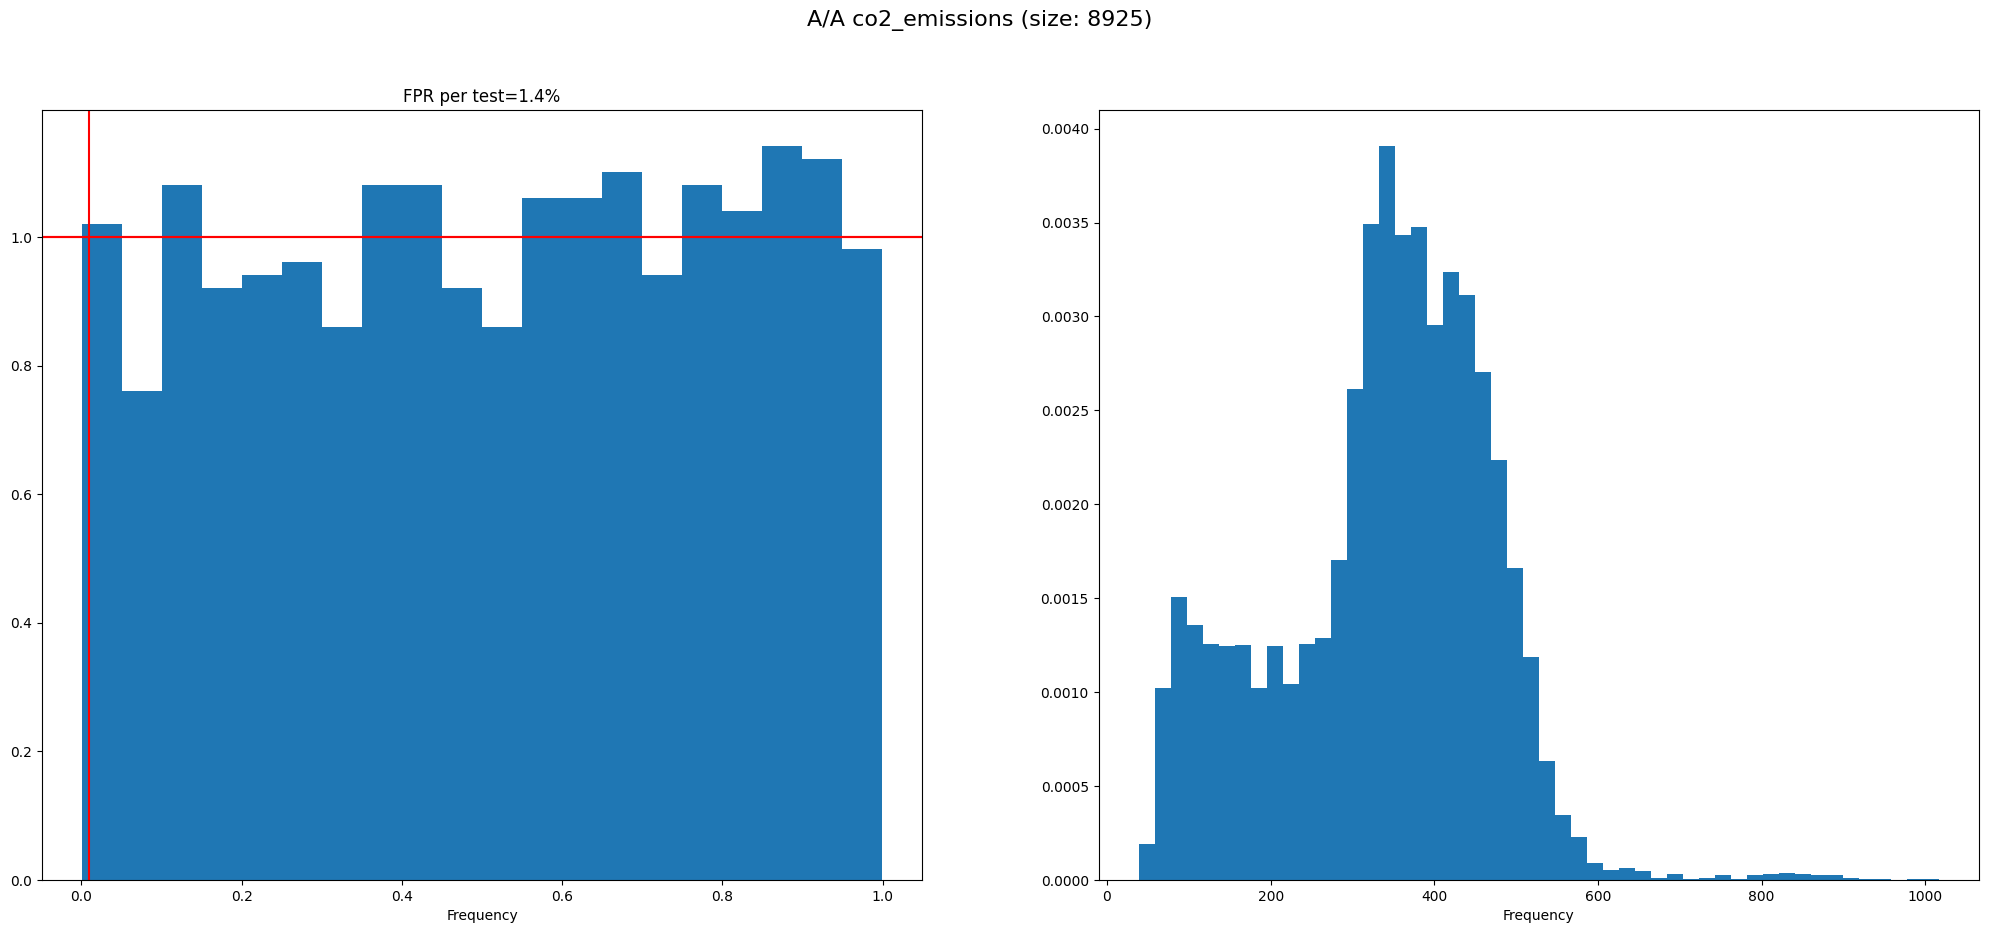

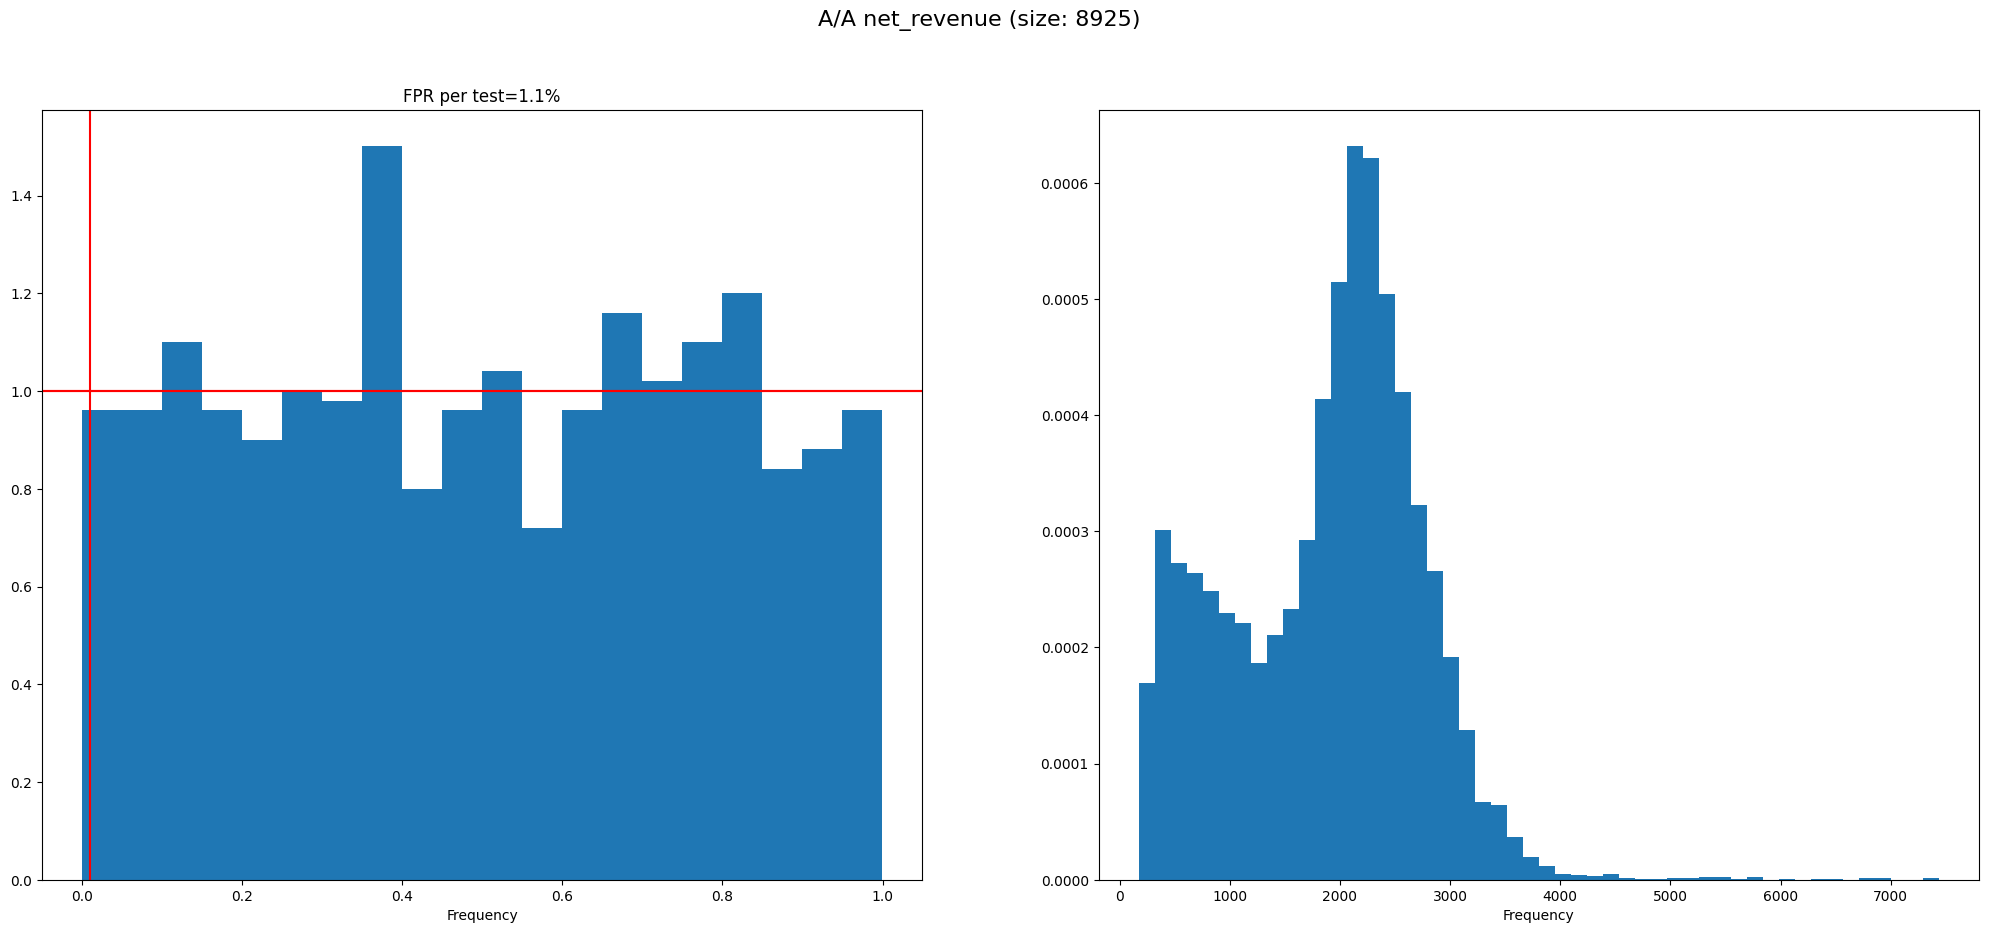

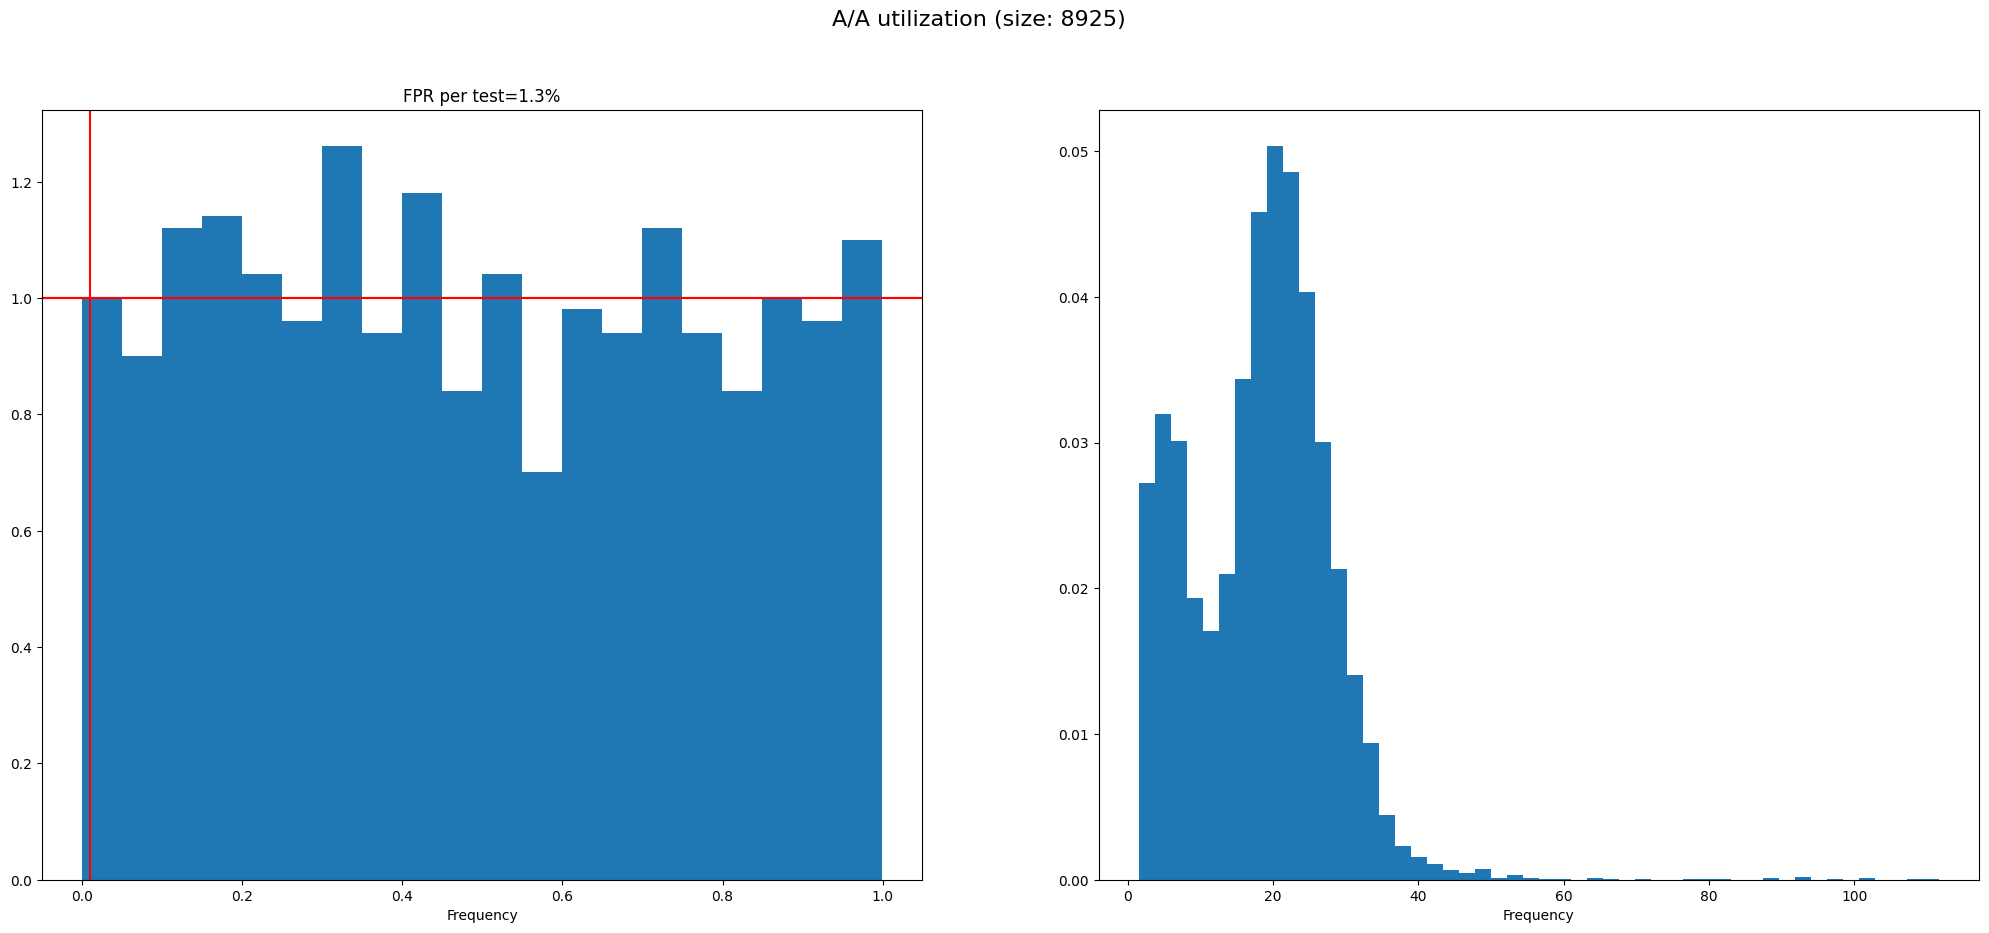

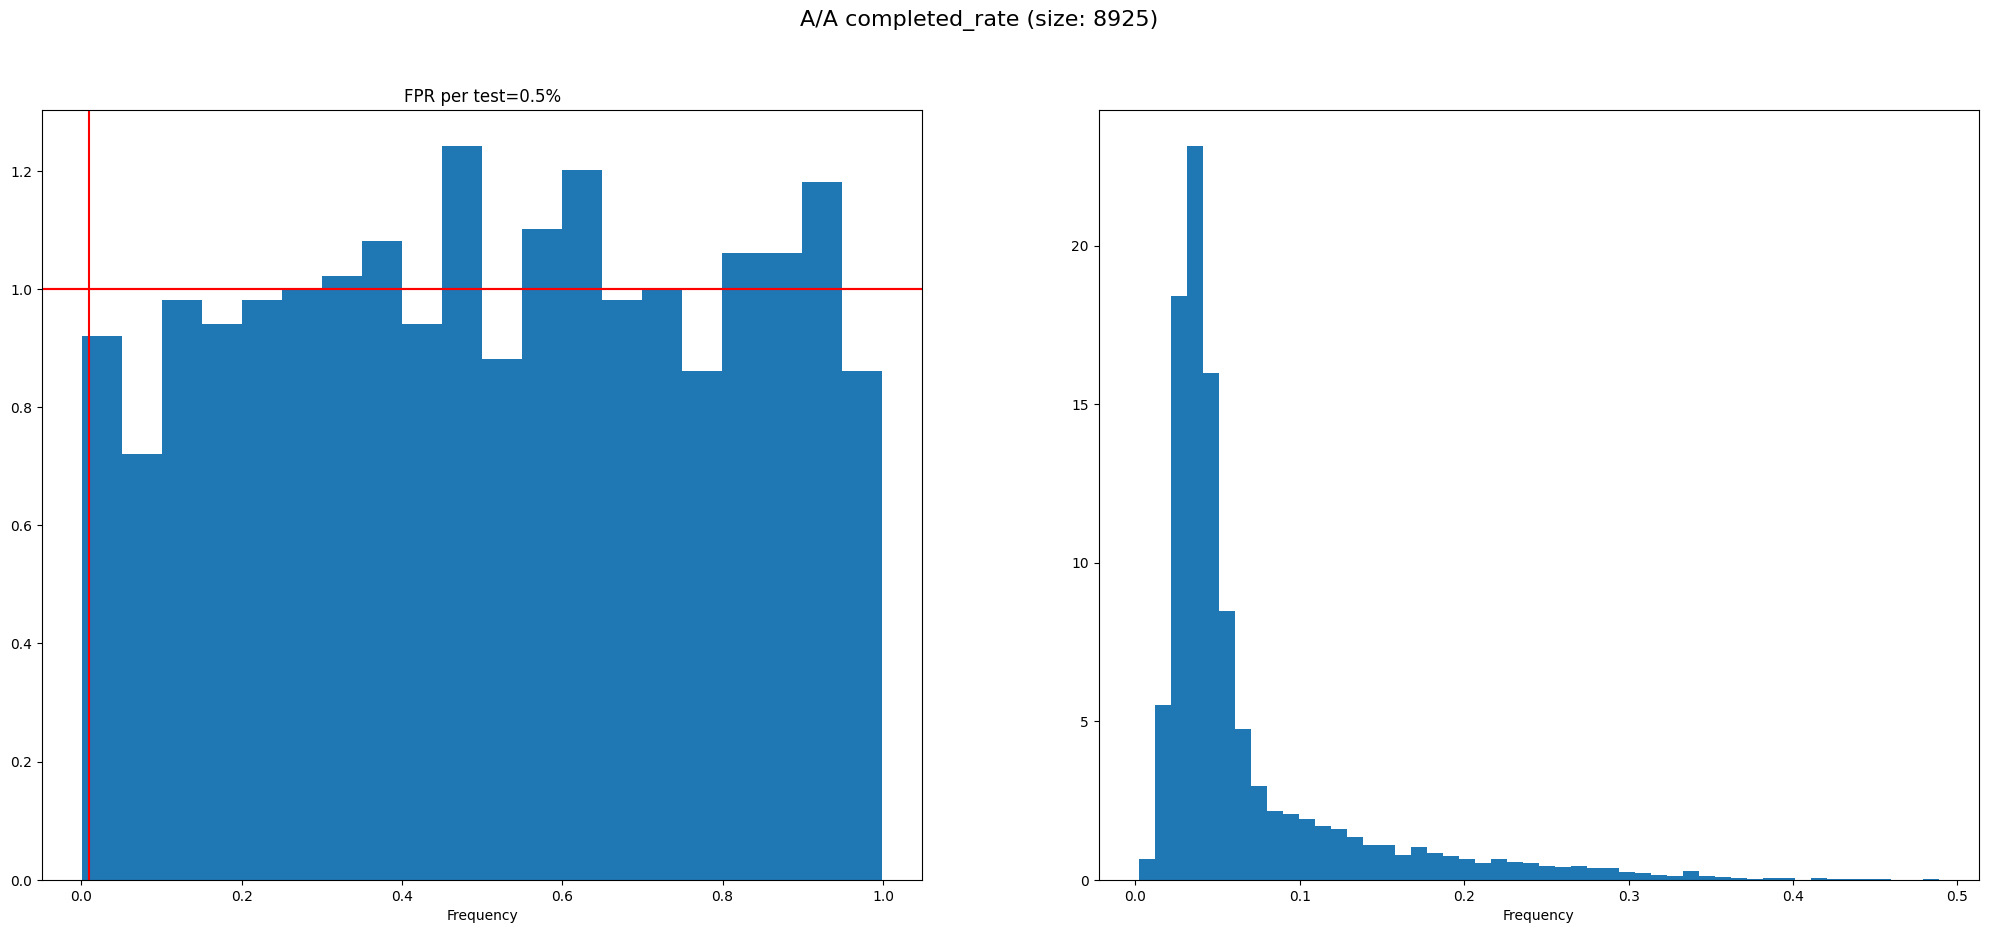

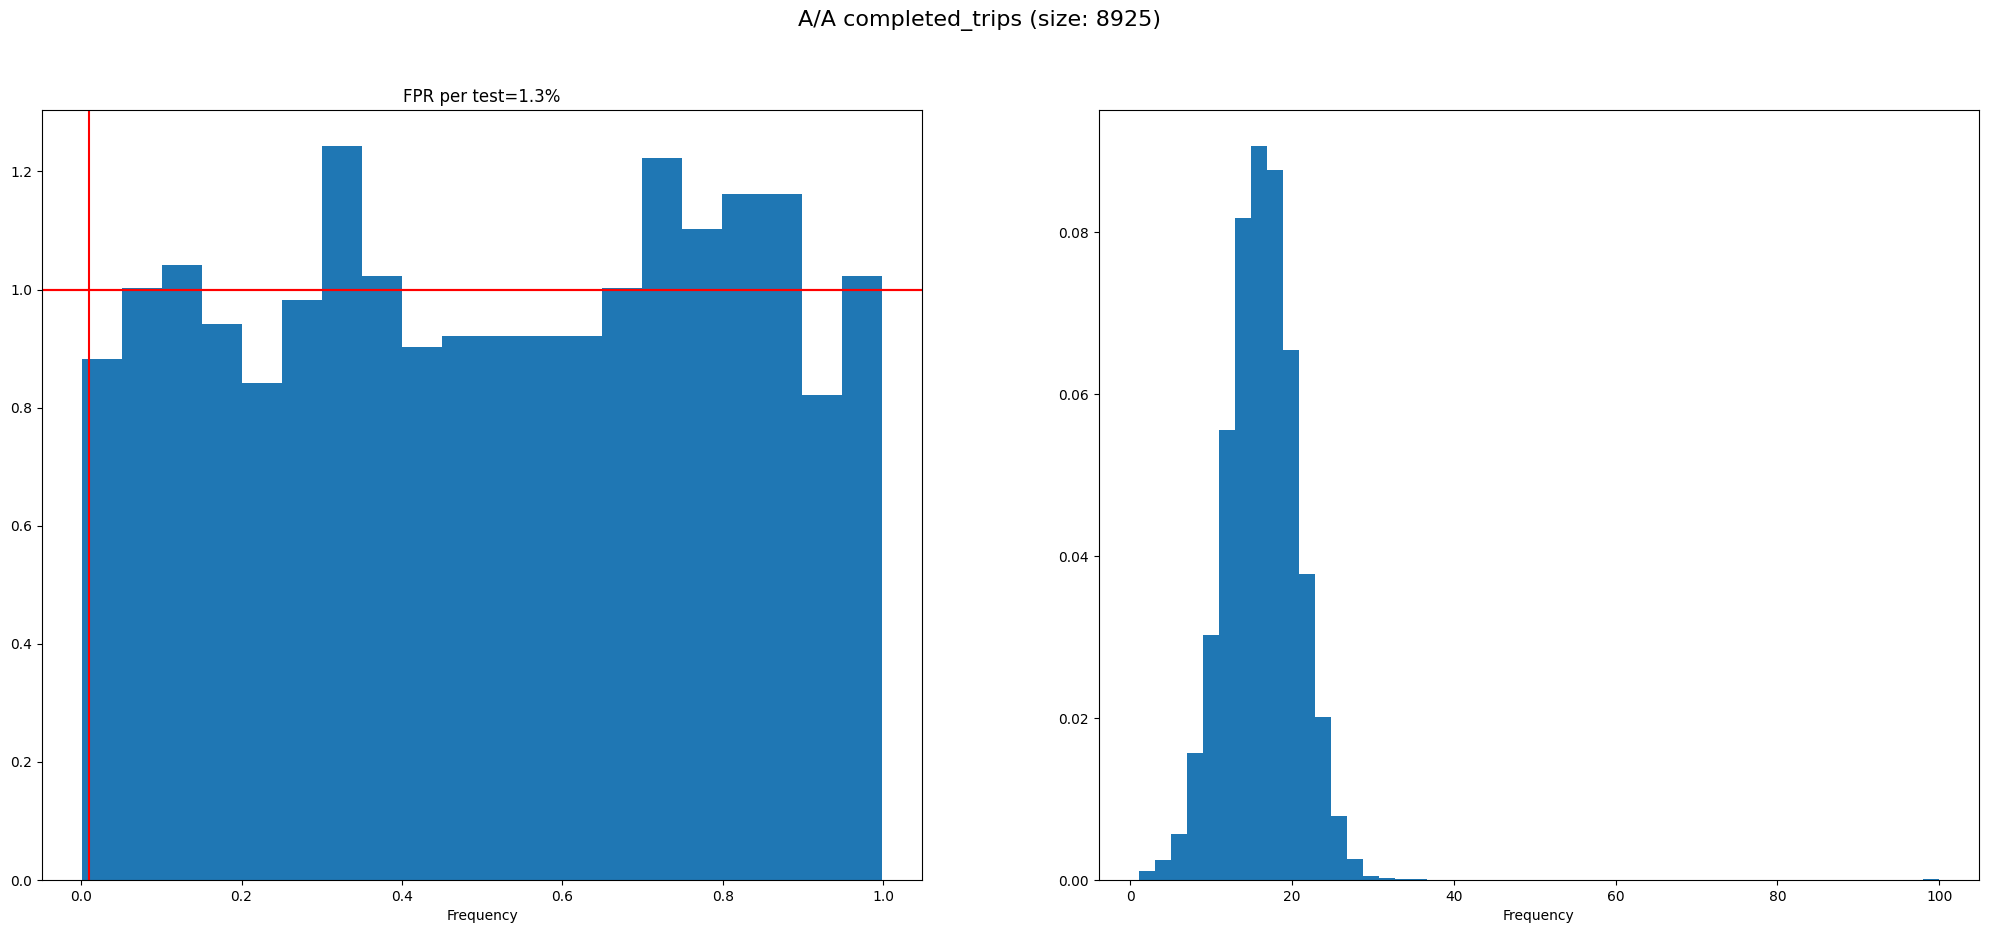

In [8]:
N = 1000
metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_rate': {'nominator': 'completed_trips', 'denominator': 'cnt_trips'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }

for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    p_values = check_aa(metrics, nominator=nom, denominator=den, N=N)

    metric_value = metrics[nom]/metrics[den]
    plot_cdf(p_values.reshape(N), metric_value, f'A/A {metric_name}', alpha=0.01)

In [9]:
for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    effect_size = get_parameter_size(nominator=metrics[nom], parameter='effect', denominator=metrics[den], alpha=0.01)
    print(f'{metric_name}: ', effect_size)

co2_emissions:  2.78
net_revenue:  3.32
utilization:  3.52
completed_rate:  3.82
completed_trips:  2.05


# 3 min agg

In [13]:
on_line_cars = pd.read_parquet('../results/saev_online_cars_day_100.parquet')
on_line_cars['agg'] = pd.to_datetime(on_line_cars['timestamp']).dt.floor('3min')

trips_table = pd.read_parquet('../results/saev_completed_trips_day_100.parquet')

trips_table['agg'] = trips_table['request_datetime'].dt.floor('3min')
trips_table['net_revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee'] - trips_table['driver_pay']
trips_table['revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']

assigned = trips_table[trips_table['assigned'] == True]


metrics = trips_table.groupby('agg')[['net_revenue', 'revenue', 'trip_time', 'trip_miles']].sum().reset_index()\
                .rename(columns={'trip_time': 'time_with_passenger'})

aggregated_on_line_cars = on_line_cars.groupby(['agg', 'car_id'])['timestamp'].agg(['min', 'max'])
aggregated_on_line_cars['on_line_time'] = (pd.to_datetime(aggregated_on_line_cars['max']) - pd.to_datetime(aggregated_on_line_cars['min']))\
                            .dt.total_seconds()
metrics = metrics.merge(aggregated_on_line_cars.groupby(['agg'])['on_line_time'].sum().reset_index(), on='agg')

metrics = metrics.merge(trips_table.pivot_table(index='agg', 
                        columns='assigned', 
                        values='trip_id', 
                        aggfunc='count').reset_index().rename(columns={False:'missed_trips', True:'completed_trips'}),
                      on='agg')

metrics['cnt_trips'] = metrics['completed_trips'] + metrics['missed_trips']

co2_per_km = 0.4 
metrics['co2_emissions'] = co2_per_km * metrics['trip_miles'] * 0.62 # 06 miles = 1 km 

metrics['default'] = 1

In [15]:
len(metrics)

14875

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1089.86it/s]


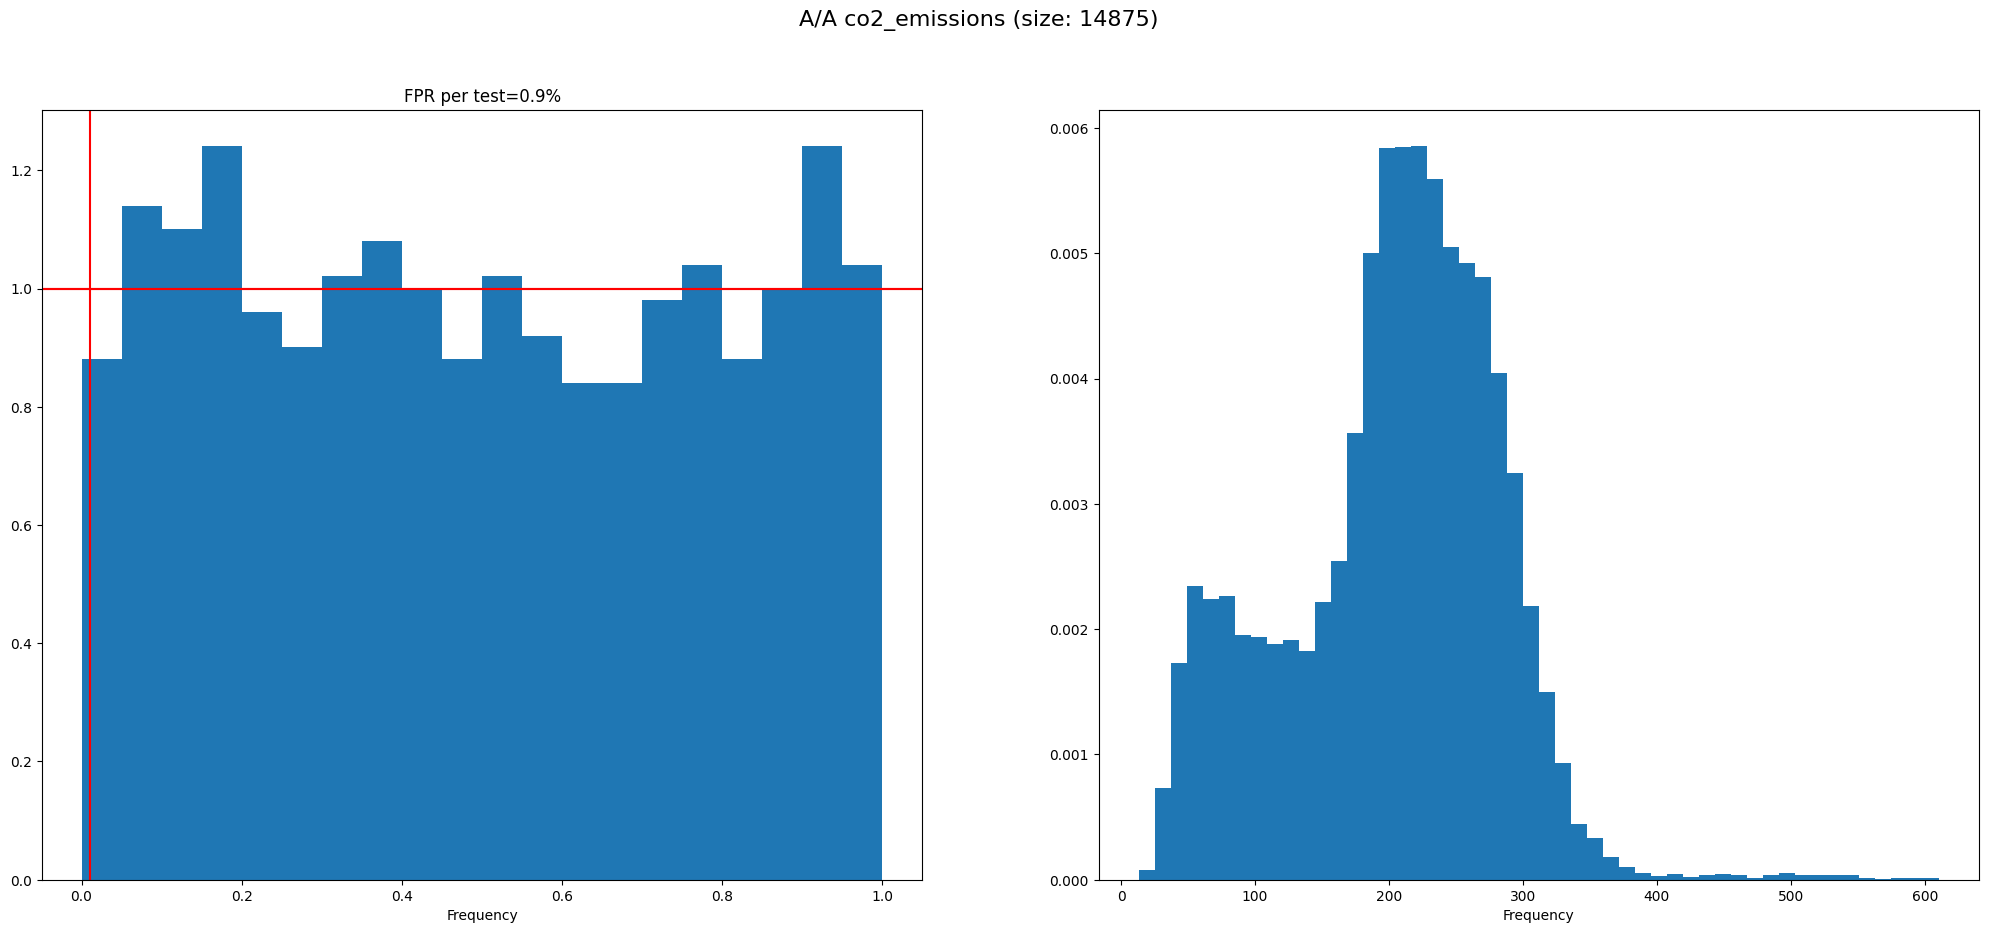

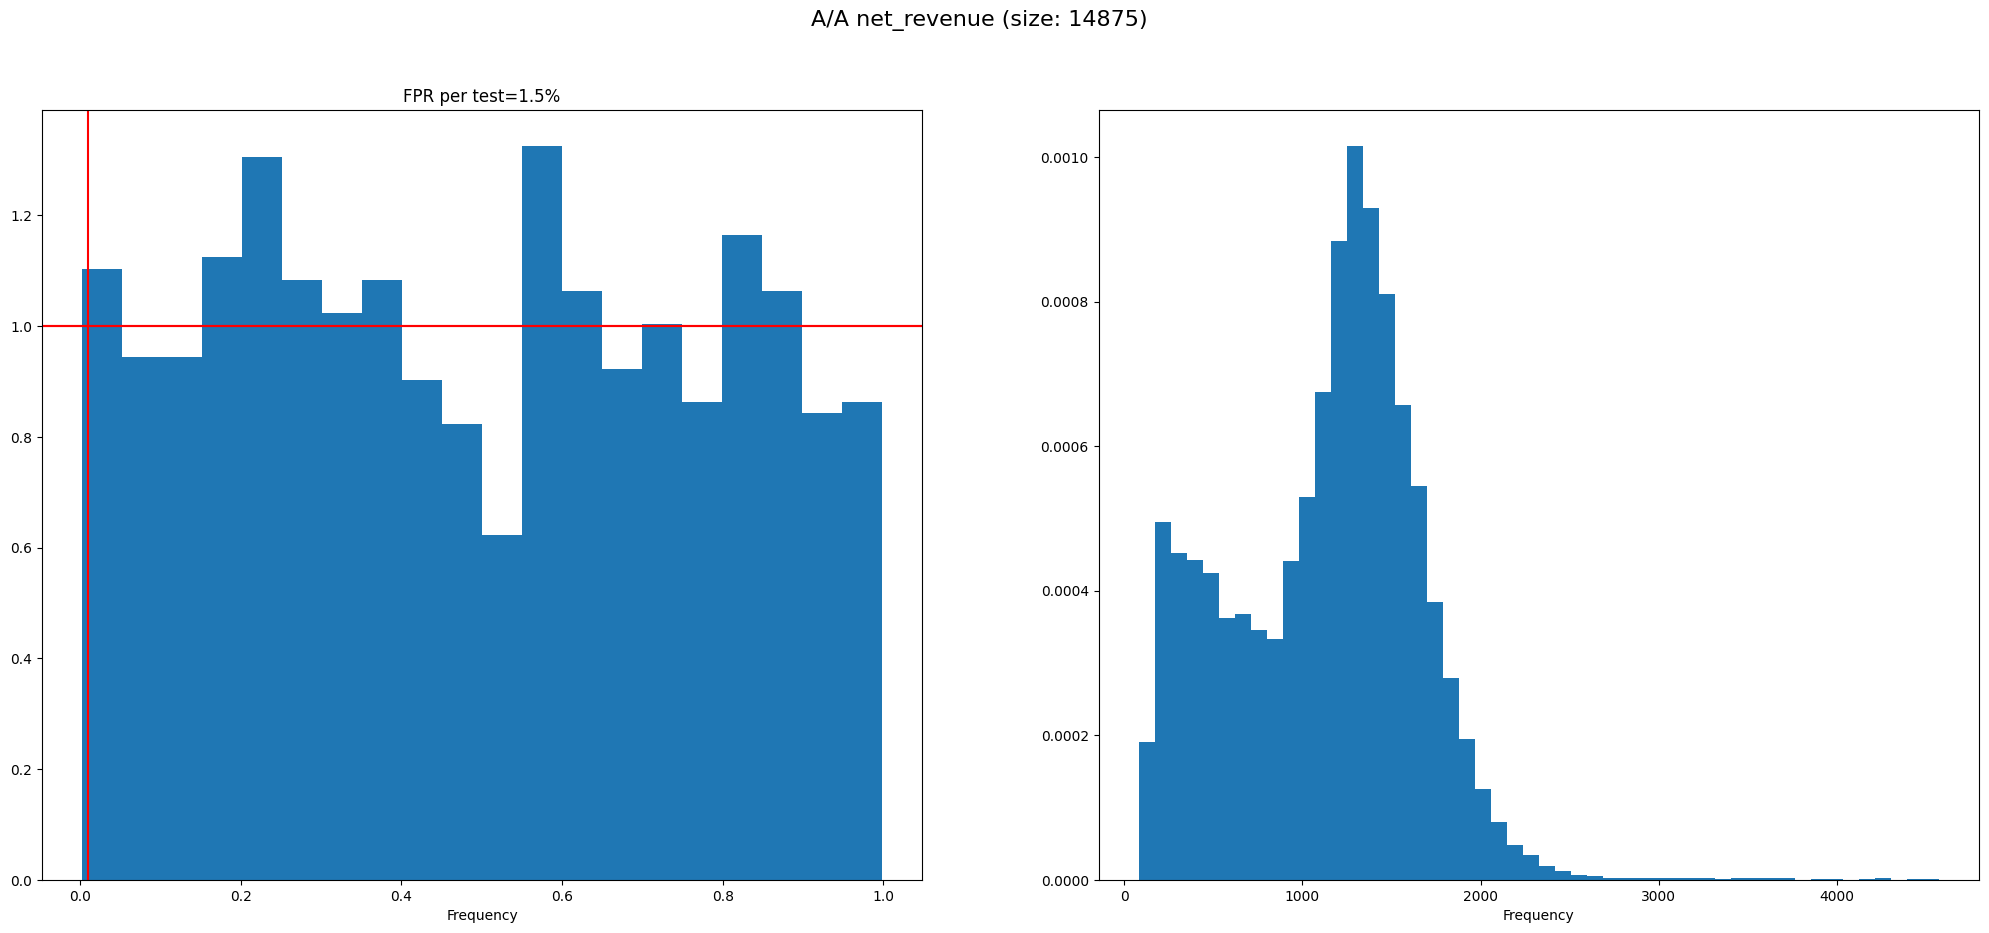

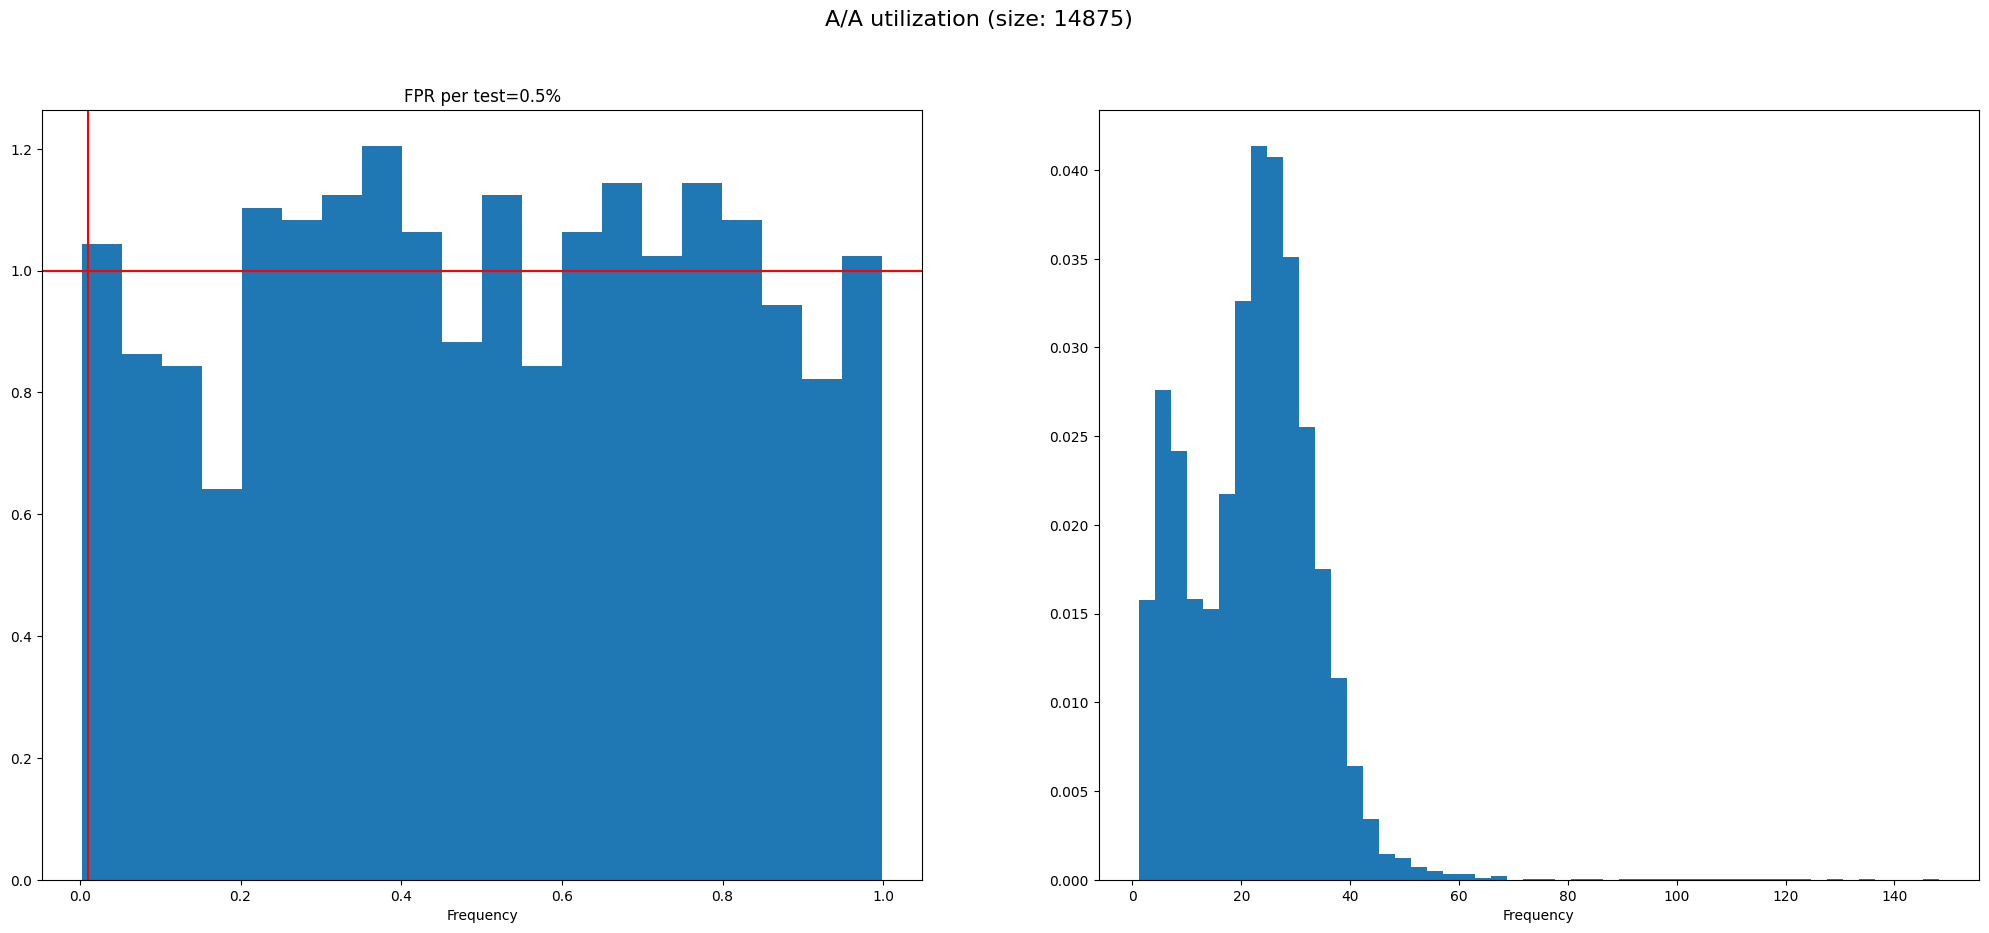

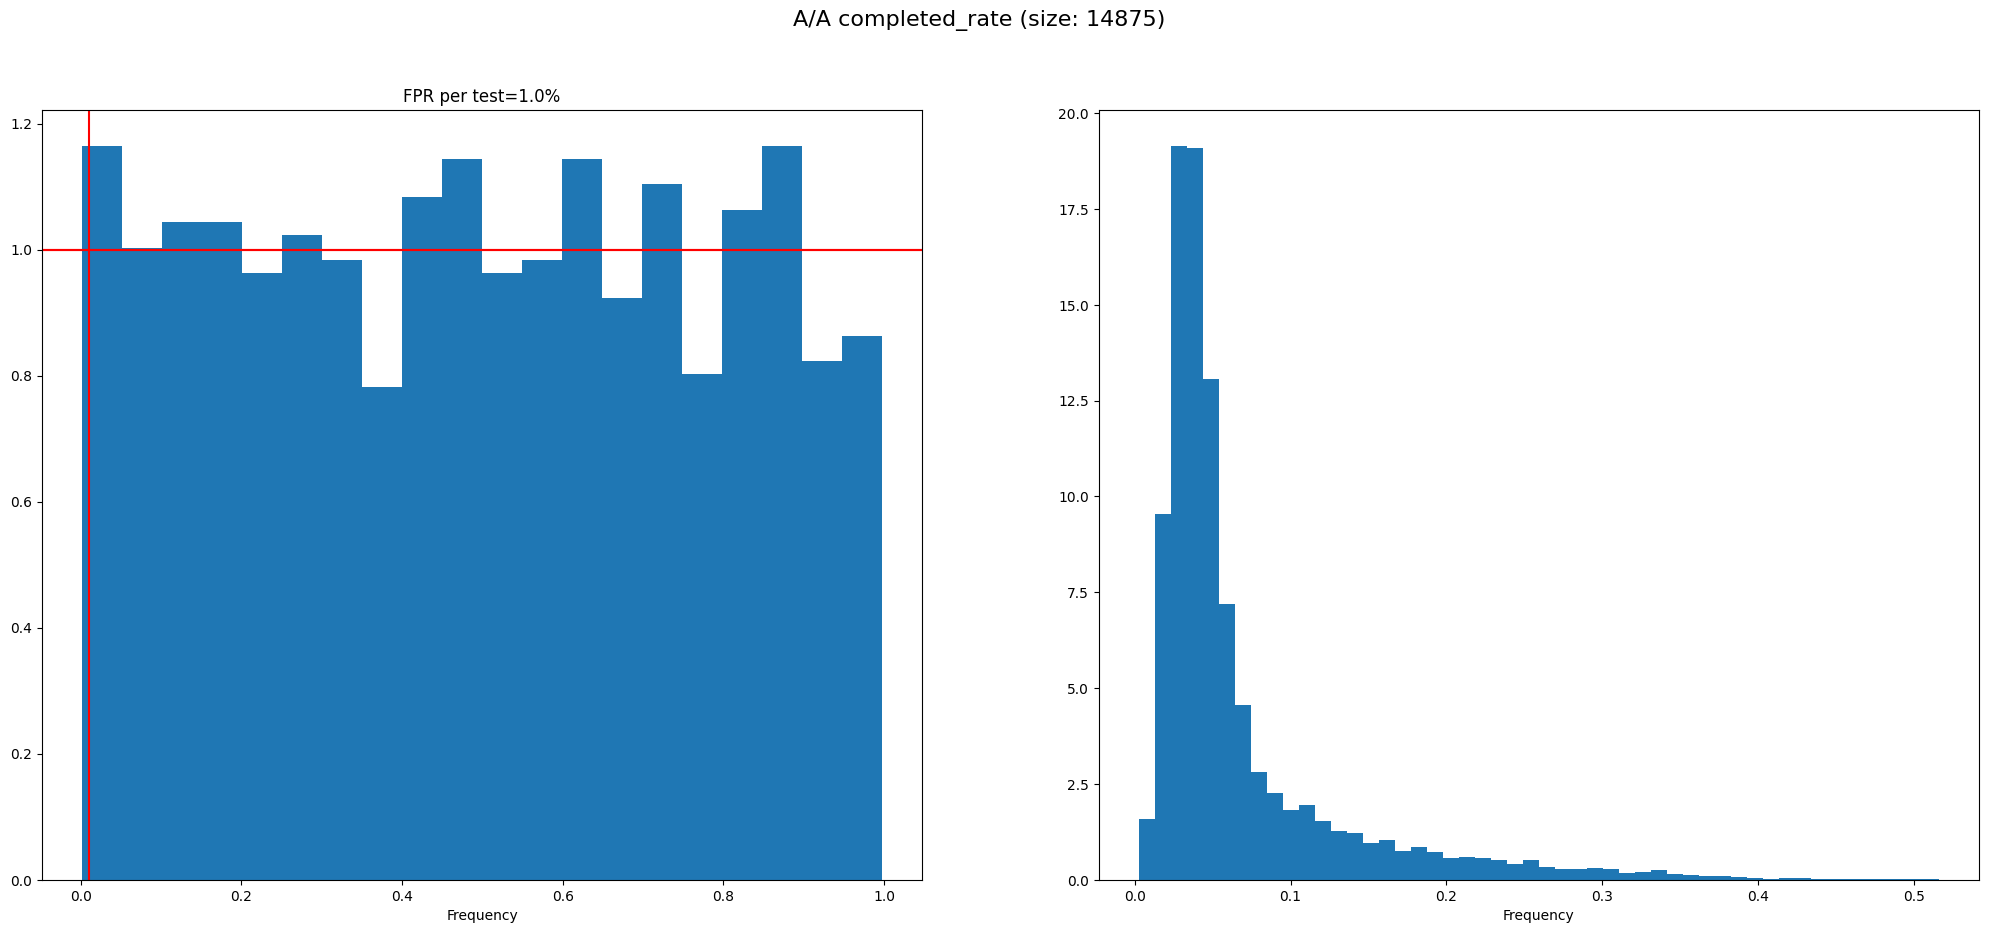

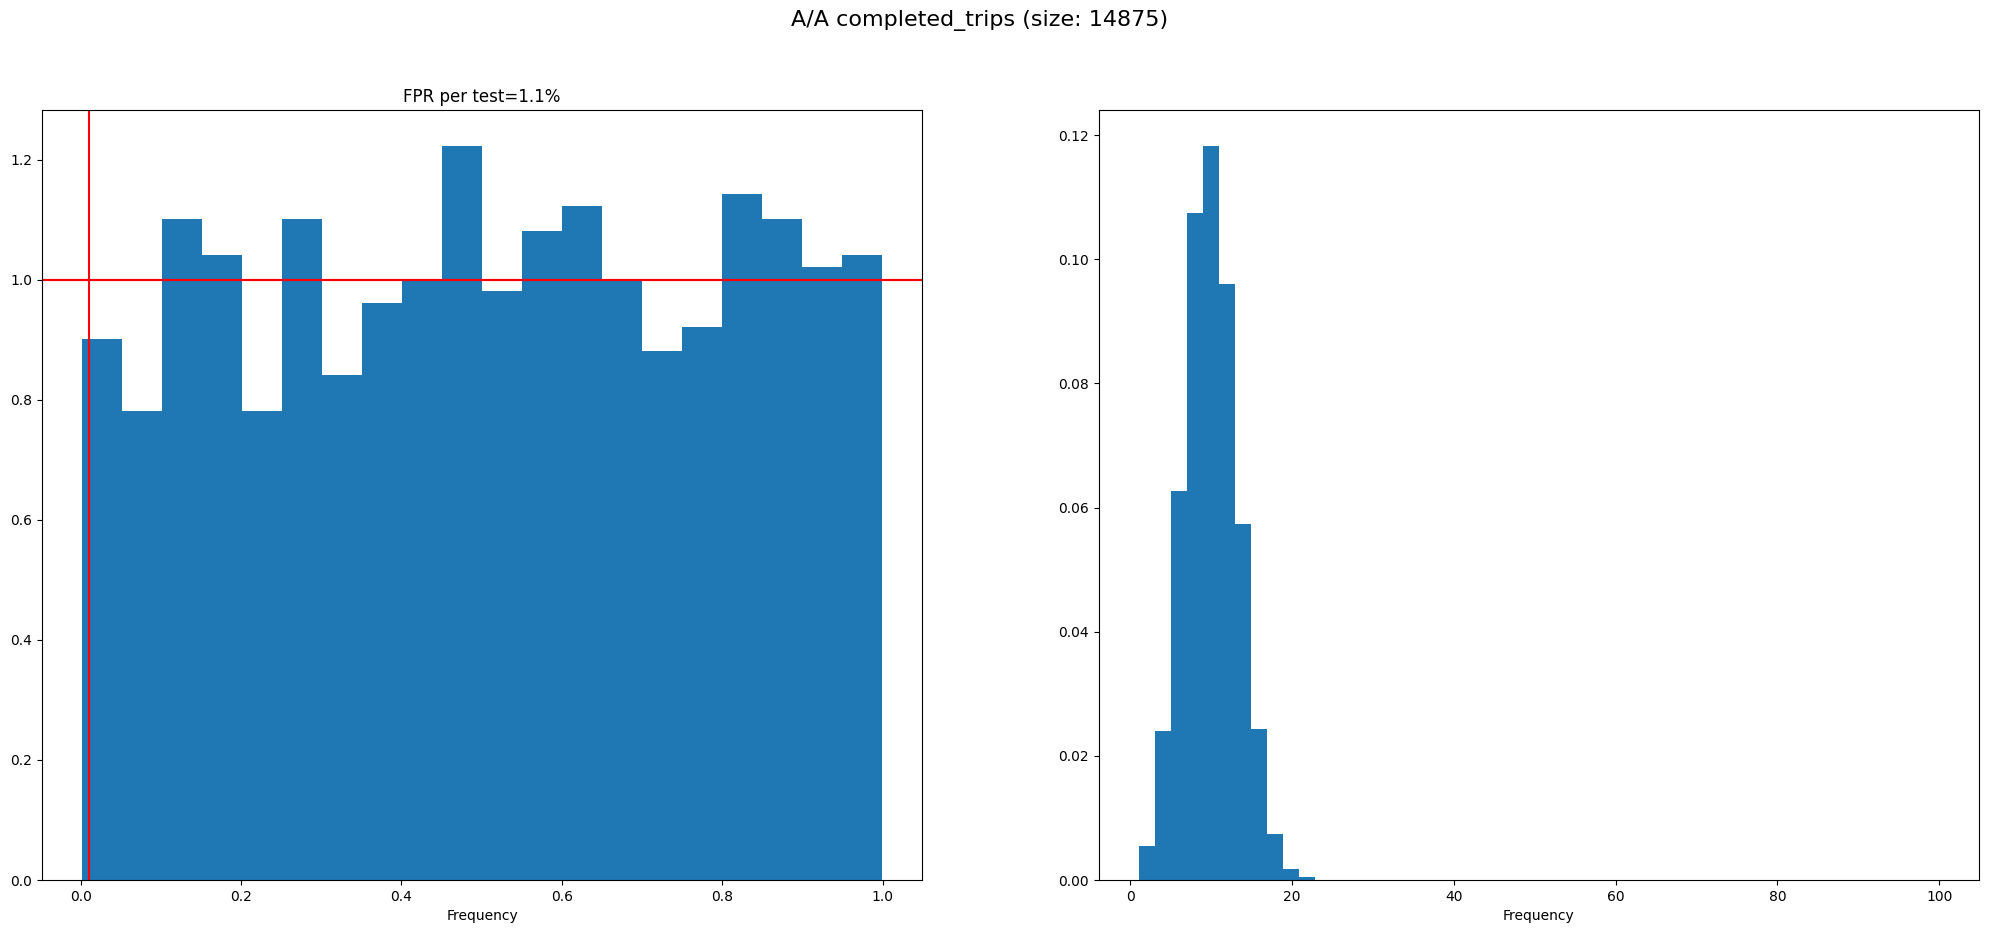

In [14]:
N = 1000
metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_rate': {'nominator': 'completed_trips', 'denominator': 'cnt_trips'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }

for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    p_values = check_aa(metrics, nominator=nom, denominator=den, N=N)

    metric_value = metrics[nom]/metrics[den]
    plot_cdf(p_values.reshape(N), metric_value, f'A/A {metric_name}', alpha=0.01)

In [16]:
for metric_key, metric_value in metric_description.items():
    nom = metric_value['nominator']
    den = metric_value['denominator']
    metric_name = metric_key
    
    effect_size = get_parameter_size(nominator=metrics[nom], parameter='effect', denominator=metrics[den], alpha=0.01)
    print(f'{metric_name}: ', effect_size)

co2_emissions:  2.18
net_revenue:  2.6
utilization:  2.74
completed_rate:  3.18
completed_trips:  1.98
